<a href="https://colab.research.google.com/github/alcorama/Repo1/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%92%D0%B5%D0%B1%D0%B8%D0%BD%D0%B0%D1%80_18_%D0%B8%D1%8E%D0%BD%D1%8F_%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B5_ML_%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D1%8B%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ВЕБИНАР 18-06: Классический ML**

## **1. Линейная регрессия (Linear Regression)**

Линейная регрессия - это простой и широко используемый метод машинного обучения для задач регрессии. Она предполагает, что зависимость между признаками (независимыми переменными) и целевой переменной (зависимой переменной) является линейной.

### **Теория**

Основная идея линейной регрессии заключается в нахождении прямой линии, которая наилучшим образом описывает зависимость между признаками и целевой переменной. Эта линия называется линией регрессии.

**Пример:**

Предположим, у нас есть небольшая таблица с данными о фруктах, включающая такие признаки, как вес, цвет и тип фрукта. Мы хотим предсказать вес фрукта на основе этих признаков.

| Вес (г) | Цвет       | Тип фрукта |
|---------|------------|------------|
| 150     | Красный    | Яблоко     |
| 180     | Зеленый    | Яблоко     |
| 200     | Желтый     | Банан      |
| 170     | Красный    | Яблоко     |
| 120     | Зеленый    | Яблоко     |
| 190     | Желтый     | Банан      |

Рассмотрим, как линейная регрессия может использовать признаки для предсказания веса фруктов.

1. **Подготовка данных:**
   - Преобразуем категориальные признаки ("Цвет" и "Тип фрукта") в числовые значения.
   - Например, "Цвет": Красный = 1, Зеленый = 2, Желтый = 3.
   - "Тип фрукта": Яблоко = 1, Банан = 2.

2. **Построение линейной модели:**
   - Мы создаем линейное уравнение для предсказания веса, например:
     Вес = a + b1 * Цвет + b2 * Тип фрукта
   - где "a" - это свободный член (пересечение с осью Y), а "b1" и "b2" - это коэффициенты, определяющие вклад каждого признака.

3. **Обучение модели:**
   - На основе данных о фруктах мы находим значения "a", "b1" и "b2", которые минимизируют разницу между предсказанными и реальными значениями веса.

**Пример расчета:**

Для нового фрукта с зеленым цветом и типом "Яблоко" (например, второй фрукт из таблицы):

- Подставляем значения в уравнение:
  Вес = a + b1 * 2 + b2 * 1
- Если a = 50, b1 = 25, а b2 = 80, то расчет будет следующим:
  Вес = 50 + 25 * 2 + 80 * 1 = 180 г

**Преимущества линейной регрессии:**
- Простота и интерпретируемость.
- Быстрое обучение.
- Хорошо работает для линейных зависимостей.

**Недостатки линейной регрессии:**
- Не подходит для моделирования нелинейных зависимостей.
- Чувствительность к выбросам и мультиколлинеарности признаков.

### **Практика**

In [ ]:
#@title Загрузка необходимых библиотек (ЗАПУСТИТЕ ЭТОТ КОД)
import pandas as pd
import numpy as np
import gdown
import warnings
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from sklearn.feature_extraction.text import CountVectorizer

URL = 'https://storage.yandexcloud.net/terraai/sources/flats.zip'
download_filename = gdown.download(URL, None, quiet=True)
!unzip -q {download_filename} -d '/content/data'
!rm -rf {download_filename}

# Игнорирование предупреждений
warnings.filterwarnings("ignore", category=UserWarning)

#@title Загрузка данных
def load_data():
    df = pd.read_csv('/content/data/flats.csv')
    df.drop(columns=['Источник', 'Бонус агенту', 'Дата', 'Кол-во дней в экспозиции'], inplace=True)
    df = df[df['Цена, тыс.руб.'] <= 300_000]
    df = df[df['Комнат'] == 1]
    df.drop(columns=['Комнат'], inplace=True)
    return df

# Очистка вывода
clear_output()

In [ ]:
#@title Сервисные функции (ЗАПУСТИТЕ ЭТОТ КОД)
#@title Преобразование текста в векторы
def text_to_vector(df, column, vector_size):
    vectorizer = CountVectorizer(max_features=vector_size, stop_words='english', token_pattern=r'\b\w+\b')
    text_vectors = vectorizer.fit_transform(df[column].astype('U')).toarray()
    text_vector_df = pd.DataFrame(text_vectors, columns=[f'{column}_vec_{i}' for i in range(vector_size)])
    df = pd.concat([df.reset_index(drop=True), text_vector_df.reset_index(drop=True)], axis=1)
    df.drop(columns=[column], inplace=True)
    return df

# Функция предобработки данных
def preprocess_data(df):
    # Обработка пропущенных значений
    df = df.dropna()

    # Список столбцов для OHE, исключаем 'Этаж' и 'Всего этажей в доме'
    categorical_columns = ['Тип дома', 'Балконы', 'Лоджии', 'Станция метро', 'Пешком или на транспорте', 'Санузел', 'Тип санузла']

    # Применение OHE
    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True, dtype=np.int8)

    # Нормирование столбцов Время в пути, Площадь, Этаж и Всего этажей в доме
    scaler_time = StandardScaler()
    scaler_area = StandardScaler()
    scaler_floor = StandardScaler()
    scaler_total_floors = StandardScaler()

    df[['Время в пути']] = scaler_time.fit_transform(df[['Время в пути']])
    df[['Площадь']] = scaler_area.fit_transform(df[['Площадь']])
    df[['Этаж']] = scaler_floor.fit_transform(df[['Этаж']])
    df[['Всего этажей в доме']] = scaler_total_floors.fit_transform(df[['Всего этажей в доме']])

    # Расчет средней стоимости до нормализации
    mean_price = df['Цена, тыс.руб.'].mean()

    return df, mean_price

#@title Нормирование целевых значений
def normalize_target(df):
    scaler_price = StandardScaler()
    df[['Цена, тыс.руб.']] = scaler_price.fit_transform(df[['Цена, тыс.руб.']])
    return df, scaler_price

#@title Разделение данных
def split_data(df, test_size):
    # Разделение данных на обучающую и тестовую выборки
    X = df.drop('Цена, тыс.руб.', axis=1)
    y = df['Цена, тыс.руб.']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

#@title Обучение модели линейной регрессии
def train_lr_model(X_train, y_train):
    # Создание и обучение модели линейной регрессии
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    return lr

#@title Оценка модели
def evaluate_model(model, X_test, y_test, scaler_price, mean_price):
    # Предсказание и оценка модели
    y_pred = model.predict(X_test)

    # Обратное преобразование нормализованных значений
    y_test_orig = scaler_price.inverse_transform(y_test.values.reshape(-1, 1)).flatten()
    y_pred_orig = scaler_price.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    mae = mean_absolute_error(y_test_orig, y_pred_orig) / 1000  # Преобразуем в млн руб

    # Преобразуем среднюю стоимость в млн руб
    mean_price_mln = mean_price / 1000

    # Расчет процентной ошибки
    percentage_error = (mae / mean_price_mln) * 100

    print(f'Средняя абсолютная ошибка (MAE): {mae:.2f} млн руб.')
    print(f'Средняя стоимость на всей выборке: {mean_price_mln:.2f} млн руб.')
    print(f'Процентная ошибка: {percentage_error:.2f}%')

    # Вывод первых нескольких предсказанных и реальных значений
    comparison = pd.DataFrame({'Предсказанное': y_pred_orig / 1000, 'Реальное': y_test_orig / 1000}).head(10)  # Преобразуем в млн руб
    print("Сравнение предсказанных и реальных значений:")
    print(comparison)

    # Построение графика предсказанных и реальных значений
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test_orig / 1000, y=y_pred_orig / 1000)  # Преобразуем в млн руб
    plt.plot([y_test_orig.min() / 1000, y_test_orig.max() / 1000], [y_test_orig.min() / 1000, y_test_orig.max() / 1000], 'r--')  # Преобразуем в млн руб
    plt.xlabel('Реальные значения (млн руб.)')
    plt.ylabel('Предсказанные значения (млн руб.)')
    plt.title('Сравнение реальных и предсказанных значений')
    plt.grid(True)
    plt.show()

In [ ]:
# Загружаем данные
df = load_data()
df

,Станция метро,Время в пути,Пешком или на транспорте,Этаж,Всего этажей в доме,Тип дома,Балконы,Лоджии,Санузел,Тип санузла,Площадь,"Цена, тыс.руб.",Примечание
0,Шелепиха м.,12,Пешком,35,37,Монолитный,0,0,2,Не указано,64.1,19500.00,Собственность оформлена! Ключи на руках! Опера...
1,Пятницкое шоссе м.,30,На транспорте,11,14,Панельный,0,1,1,Раздельный,38.4,4800.00,Зеленоград к.1820 однокомнатная квартира общ.3...
2,Планерная м.,5,На транспорте,11,22,Панельный,1,0,1,Совмещенный,38.2,7990.00,"Уютная, светлая квартира, застекленный балкон ..."
3,Шаболовская м.,12,Пешком,8,12,Не указано,1,0,1,Раздельный,38.0,11200.00,"Предлагаю 1- комн квартиру, в шаговой доступно..."
4,Бабушкинская м.,15,Пешком,4,14,Панельный,0,0,1,Совмещенный,34.0,6250.00,Продается хорошая 1 комнатная квартира. 1 взро...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
126263,Некрасовка м.,4,Пешком,2,17,Панельный,0,0,1,Не указано,19.8,2850.00,Уникальнейшее предложение! 7 минуты до метро! ...
126264,Авиамоторная м.,6,Пешком,2,8,Кирпичный,0,0,1,Совмещенный,20.4,3839.99,ВЫГОДНОЕ ПРЕДЛОЖЕНИЕ в пешей доступности от ме...
126265,Коломенская м.,15,Пешком,1,9,Панельный,0,0,1,Не указано,15.4,2900.00,СТУДИЯ В МОСКВЕ ПО ДОСТУПНОЙ ЦЕНЕ ! __________...
126266,Алтуфьево м.,5,На транспорте,4,9,Монолитный,0,0,1,Не указано,26.0,5200.00,Продается студия с отделкой в новом монолитном...


In [ ]:
# Предобработка данных и расчет средней стоимости
df, mean_price = preprocess_data(df)
# Нормирование целевых значений
df, scaler_price = normalize_target(df)
df

,Время в пути,Этаж,Всего этажей в доме,Площадь,"Цена, тыс.руб.",Примечание,Тип дома_Деревянный,Тип дома_Железо-бетонный,Тип дома_Кирпичный,Тип дома_Монолитный,...,Станция метро_Южная м.,Станция метро_Ясенево м.,Пешком или на транспорте_Не указано,Пешком или на транспорте_Пешком,Санузел_1,Санузел_2,Санузел_3,Санузел_4,Тип санузла_Раздельный,Тип санузла_Совмещенный
0,0.325092,2.856728,1.718539,1.132717,1.080862,Собственность оформлена! Ключи на руках! Опера...,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
1,2.726350,0.117504,-0.419261,-0.118080,-0.418863,Зеленоград к.1820 однокомнатная квартира общ.3...,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,-0.608731,0.117504,0.324321,-0.127814,-0.093412,"Уютная, светлая квартира, застекленный балкон ...",0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0.325092,-0.224899,-0.605157,-0.137547,0.234079,"Предлагаю 1- комн квартиру, в шаговой доступно...",0,0,0,0,...,0,0,0,1,1,0,0,0,1,0
4,0.725301,-0.681436,-0.419261,-0.332224,-0.270931,Продается хорошая 1 комнатная квартира. 1 взро...,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126263,-0.742134,-0.909705,-0.140418,-1.023325,-0.617806,Уникальнейшее предложение! 7 минуты до метро! ...,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
126264,-0.475328,-0.909705,-0.976948,-0.994124,-0.516805,ВЫГОДНОЕ ПРЕДЛОЖЕНИЕ в пешей доступности от ме...,0,0,1,0,...,0,0,0,1,1,0,0,0,0,1
126265,0.725301,-1.023839,-0.884000,-1.237470,-0.612704,СТУДИЯ В МОСКВЕ ПО ДОСТУПНОЙ ЦЕНЕ ! __________...,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
126266,-0.608731,-0.681436,-0.884000,-0.721577,-0.378054,Продается студия с отделкой в новом монолитном...,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
# Преобразование текста в векторы
df = text_to_vector(df, 'Примечание', vector_size=500)
df

,Время в пути,Этаж,Всего этажей в доме,Площадь,"Цена, тыс.руб.",Тип дома_Деревянный,Тип дома_Железо-бетонный,Тип дома_Кирпичный,Тип дома_Монолитный,Тип дома_Не указано,...,Примечание_vec_490,Примечание_vec_491,Примечание_vec_492,Примечание_vec_493,Примечание_vec_494,Примечание_vec_495,Примечание_vec_496,Примечание_vec_497,Примечание_vec_498,Примечание_vec_499
0,0.325092,2.856728,1.718539,1.132717,1.080862,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,2.726350,0.117504,-0.419261,-0.118080,-0.418863,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.608731,0.117504,0.324321,-0.127814,-0.093412,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.325092,-0.224899,-0.605157,-0.137547,0.234079,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0.725301,-0.681436,-0.419261,-0.332224,-0.270931,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74649,-0.742134,-0.909705,-0.140418,-1.023325,-0.617806,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
74650,-0.475328,-0.909705,-0.976948,-0.994124,-0.516805,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
74651,0.725301,-1.023839,-0.884000,-1.237470,-0.612704,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74652,-0.608731,-0.681436,-0.884000,-0.721577,-0.378054,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df # Разделение выборок на обучающую и тестовую
X_train, X_test, y_train, y_test = split_data(df, test_size=0.2)

# Вывод форм выборок
print(f'Форма X_train: {X_train.shape}')
print(f'Форма X_test: {X_test.shape}')
print(f'Форма y_train: {y_train.shape}')
print(f'Форма y_test: {y_test.shape}')

Форма X_train: (59723, 791)
Форма X_test: (14931, 791)
Форма y_train: (59723,)
Форма y_test: (14931,)


In [ ]:
# Обучение модели
model = train_lr_model(X_train, y_train)

Средняя абсолютная ошибка (MAE): 2.46 млн руб.
Средняя стоимость на всей выборке: 8.91 млн руб.
Процентная ошибка: 27.59%
Сравнение предсказанных и реальных значений:
   Предсказанное   Реальное
0      14.728325  13.000000
1      11.670127   9.400000
2      10.844020   9.300000
3       8.251121   7.100000
4      12.610250  10.326400
5       8.096401   6.999999
6       5.716549   5.100000
7       9.167113   7.490000
8      -4.742911   2.900000
9       5.989914   5.501600


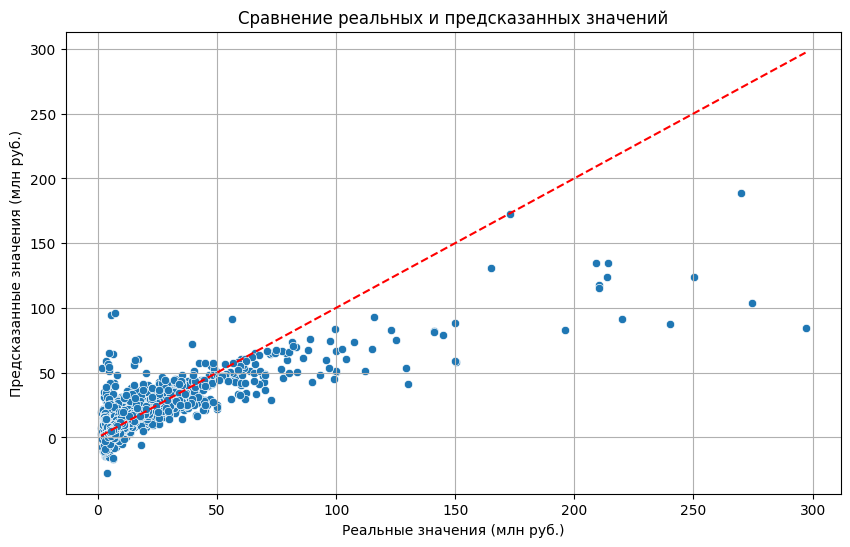

In [ ]:
# Оценка работы модели
evaluate_model(model, X_test, y_test, scaler_price, mean_price)

## **2. Метод опорных векторов для регрессии (Support Vector Regression, SVR)**

Метод опорных векторов (Support Vector Machine, SVM) - это мощный алгоритм машинного обучения, который может использоваться для задач классификации и регрессии. В случае регрессии, SVM называется Support Vector Regression (SVR).

### **Теория**

Основная идея SVR заключается в следующем:

1. **Определение функции регрессии:** SVR строит гиперплоскость (или гиперлинию в одномерном случае), которая наилучшим образом приближает зависимость между признаками и целевой переменной.
2. **Опорные векторы:** Опорные векторы - это точки данных, которые находятся ближе всего к гиперплоскости и определяют ее положение.
3. **Ядровая функция:** SVR может использовать различные ядровые функции для построения нелинейных зависимостей. Примеры ядровых функций: линейное, полиномиальное, радиально-базисное (RBF) и другие.



**Пример:**

Предположим, у нас есть небольшая таблица с данными о фруктах, включающая такие признаки, как вес, цвет и цена фрукта. Мы хотим предсказать цену фрукта на основе его веса и цвета.

Исходная таблица:

| Вес (г) | Цвет       | Цена (руб.) |
|---------|------------|-------------|
| 150     | Красный    | 50          |
| 180     | Зеленый    | 55          |
| 200     | Желтый     | 60          |
| 170     | Красный    | 52          |
| 120     | Зеленый    | 48          |
| 190     | Желтый     | 58          |

После преобразования:

| Вес (г) | Цвет | Цена (руб.) |
|---------|------|-------------|
| 150     | 1    | 50          |
| 180     | 2    | 55          |
| 200     | 3    | 60          |
| 170     | 1    | 52          |
| 120     | 2    | 48          |
| 190     | 3    | 58          |

Теперь метод опорных векторов найдет гиперплоскость, которая наилучшим образом аппроксимирует зависимость между весом, цветом и ценой фрукта.

1. **Начальные данные:**
   - Вес: 175 г
   - Цвет: 2 (зеленый)

2. **Гиперплоскость:**
   - Гиперплоскость может быть представлена как уравнение \( y = ax + bz + c \), где \( x \) - вес, \( z \) - цвет, \( y \) - цена, \( a \), \( b \) и \( c \) - коэффициенты.

Предположим, что на основании наших данных, модель вычислила коэффициенты \( a = 0.2 \), \( b = 5 \) и \( c = 20 \).

3. **Решение:**
   - Подставляем значения веса и цвета в уравнение гиперплоскости:
   \( y = 0.2x175 + 5x2 + 20 \)
   - Выполняем расчет:
   \( y = 35 + 10 + 20 = 65 \)

   Таким образом, предсказанная цена фрукта с весом 175 г и цветом 2 (зеленый) будет 65 руб.

Этот пример демонстрирует, как метод опорных векторов может быть использован для предсказания цены фруктов на основе их веса и цвета, строя гиперплоскость, которая наилучшим образом приближает зависимость между признаками и целевой переменной.

**Преимущества метода опорных векторов:**
- Эффективен в высокоразмерных пространствах.
- Работает хорошо, когда число признаков больше числа образцов.
- Использует подмножество обучающих точек (опорные векторы), что делает его память-эффективным.

**Недостатки метода опорных векторов:**
- Не работает хорошо с большими наборами данных из-за вычислительной сложности.
- Не работает хорошо, когда данные имеют много шума (например, классы сильно перекрываются).
- Выбор ядровой функции и параметров модели может быть сложным.

### **Практика**

In [ ]:
#@title Загрузка необходимых библиотек (ЗАПУСТИТЕ ЭТОТ КОД)
import pandas as pd
import numpy as np
import gdown
import warnings
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from sklearn.feature_extraction.text import CountVectorizer

# Загрузка и распаковка данных
URL = 'https://storage.yandexcloud.net/terraai/sources/flats.zip'
download_filename = gdown.download(URL, None, quiet=True)
!unzip -q {download_filename} -d '/content/data'
!rm -rf {download_filename}

# Игнорирование предупреждений
warnings.filterwarnings("ignore", category=UserWarning)

#@title Загрузка данных
def load_data():
    df = pd.read_csv('/content/data/flats.csv')
    df.drop(columns=['Источник', 'Бонус агенту', 'Дата', 'Кол-во дней в экспозиции'], inplace=True)
    df = df[df['Цена, тыс.руб.'] <= 300_000]
    df = df[df['Комнат'] == 1]
    df.drop(columns=['Комнат'], inplace=True)
    return df

# Очистка вывода
clear_output()

In [ ]:
#@title Сервисные функции (ЗАПУСТИТЕ ЭТОТ КОД)
#@title Преобразование текста в векторы
def text_to_vector(df, column, vector_size):
    vectorizer = CountVectorizer(max_features=vector_size, stop_words='english', token_pattern=r'\b\w+\b')
    text_vectors = vectorizer.fit_transform(df[column].astype('U')).toarray()
    text_vector_df = pd.DataFrame(text_vectors, columns=[f'{column}_vec_{i}' for i in range(vector_size)])
    df = pd.concat([df.reset_index(drop=True), text_vector_df.reset_index(drop=True)], axis=1)
    df.drop(columns=[column], inplace=True)
    return df

# Функция предобработки данных
def preprocess_data(df):
    # Обработка пропущенных значений
    df = df.dropna()

    # Список столбцов для OHE, исключаем 'Этаж' и 'Всего этажей в доме'
    categorical_columns = ['Тип дома', 'Балконы', 'Лоджии', 'Станция метро', 'Пешком или на транспорте', 'Санузел', 'Тип санузла']

    # Применение OHE
    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True, dtype=np.int8)

    # Нормирование столбцов Время в пути, Площадь, Этаж и Всего этажей в доме
    scaler_time = StandardScaler()
    scaler_area = StandardScaler()
    scaler_floor = StandardScaler()
    scaler_total_floors = StandardScaler()

    df[['Время в пути']] = scaler_time.fit_transform(df[['Время в пути']])
    df[['Площадь']] = scaler_area.fit_transform(df[['Площадь']])
    df[['Этаж']] = scaler_floor.fit_transform(df[['Этаж']])
    df[['Всего этажей в доме']] = scaler_total_floors.fit_transform(df[['Всего этажей в доме']])

    # Расчет средней стоимости до нормализации
    mean_price = df['Цена, тыс.руб.'].mean()

    return df, mean_price

#@title Нормирование целевых значений
def normalize_target(df):
    scaler_price = StandardScaler()
    df[['Цена, тыс.руб.']] = scaler_price.fit_transform(df[['Цена, тыс.руб.']])
    return df, scaler_price

#@title Разделение данных
def split_data(df, test_size):
    # Разделение данных на обучающую и тестовую выборки
    X = df.drop('Цена, тыс.руб.', axis=1)
    y = df['Цена, тыс.руб.']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

#@title Обучение модели SVR
def train_svr_model(X_train, y_train, kernel='linear', **kwargs):
    # Создание и обучение модели SVR
    svr = SVR(kernel=kernel, **kwargs)
    svr.fit(X_train, y_train)
    return svr

#@title Оценка модели
def evaluate_model(model, X_test, y_test, scaler_price, mean_price):
    # Предсказание и оценка модели
    y_pred = model.predict(X_test)

    # Обратное преобразование нормализованных значений
    y_test_orig = scaler_price.inverse_transform(y_test.values.reshape(-1, 1)).flatten()
    y_pred_orig = scaler_price.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    mae = mean_absolute_error(y_test_orig, y_pred_orig) / 1000  # Преобразуем в млн руб

    # Преобразуем среднюю стоимость в млн руб
    mean_price_mln = mean_price / 1000

    # Расчет процентной ошибки
    percentage_error = (mae / mean_price_mln) * 100

    print(f'Средняя абсолютная ошибка (MAE): {mae:.2f} млн руб.')
    print(f'Средняя стоимость на всей выборке: {mean_price_mln:.2f} млн руб.')
    print(f'Процентная ошибка: {percentage_error:.2f}%')

    # Вывод первых нескольких предсказанных и реальных значений
    comparison = pd.DataFrame({'Предсказанное': y_pred_orig / 1000, 'Реальное': y_test_orig / 1000}).head(10)  # Преобразуем в млн руб
    print("Сравнение предсказанных и реальных значений:")
    print(comparison)

    # Построение графика предсказанных и реальных значений
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test_orig / 1000, y=y_pred_orig / 1000)  # Преобразуем в млн руб
    plt.plot([y_test_orig.min() / 1000, y_test_orig.max() / 1000], [y_test_orig.min() / 1000, y_test_orig.max() / 1000], 'r--')  # Преобразуем в млн руб
    plt.xlabel('Реальные значения (млн руб.)')
    plt.ylabel('Предсказанные значения (млн руб.)')
    plt.title('Сравнение реальных и предсказанных значений')
    plt.grid(True)
    plt.show()

In [ ]:
# Загружаем данные
df = load_data()
df

,Станция метро,Время в пути,Пешком или на транспорте,Этаж,Всего этажей в доме,Тип дома,Балконы,Лоджии,Санузел,Тип санузла,Площадь,"Цена, тыс.руб.",Примечание
0,Шелепиха м.,12,Пешком,35,37,Монолитный,0,0,2,Не указано,64.1,19500.00,Собственность оформлена! Ключи на руках! Опера...
1,Пятницкое шоссе м.,30,На транспорте,11,14,Панельный,0,1,1,Раздельный,38.4,4800.00,Зеленоград к.1820 однокомнатная квартира общ.3...
2,Планерная м.,5,На транспорте,11,22,Панельный,1,0,1,Совмещенный,38.2,7990.00,"Уютная, светлая квартира, застекленный балкон ..."
3,Шаболовская м.,12,Пешком,8,12,Не указано,1,0,1,Раздельный,38.0,11200.00,"Предлагаю 1- комн квартиру, в шаговой доступно..."
4,Бабушкинская м.,15,Пешком,4,14,Панельный,0,0,1,Совмещенный,34.0,6250.00,Продается хорошая 1 комнатная квартира. 1 взро...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
126263,Некрасовка м.,4,Пешком,2,17,Панельный,0,0,1,Не указано,19.8,2850.00,Уникальнейшее предложение! 7 минуты до метро! ...
126264,Авиамоторная м.,6,Пешком,2,8,Кирпичный,0,0,1,Совмещенный,20.4,3839.99,ВЫГОДНОЕ ПРЕДЛОЖЕНИЕ в пешей доступности от ме...
126265,Коломенская м.,15,Пешком,1,9,Панельный,0,0,1,Не указано,15.4,2900.00,СТУДИЯ В МОСКВЕ ПО ДОСТУПНОЙ ЦЕНЕ ! __________...
126266,Алтуфьево м.,5,На транспорте,4,9,Монолитный,0,0,1,Не указано,26.0,5200.00,Продается студия с отделкой в новом монолитном...


In [ ]:
# Предобработка данных и расчет средней стоимости
df, mean_price = preprocess_data(df)
# Нормирование целевых значений
df, scaler_price = normalize_target(df)
df

,Время в пути,Этаж,Всего этажей в доме,Площадь,"Цена, тыс.руб.",Примечание,Тип дома_Деревянный,Тип дома_Железо-бетонный,Тип дома_Кирпичный,Тип дома_Монолитный,...,Станция метро_Южная м.,Станция метро_Ясенево м.,Пешком или на транспорте_Не указано,Пешком или на транспорте_Пешком,Санузел_1,Санузел_2,Санузел_3,Санузел_4,Тип санузла_Раздельный,Тип санузла_Совмещенный
0,0.325092,2.856728,1.718539,1.132717,1.080862,Собственность оформлена! Ключи на руках! Опера...,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
1,2.726350,0.117504,-0.419261,-0.118080,-0.418863,Зеленоград к.1820 однокомнатная квартира общ.3...,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,-0.608731,0.117504,0.324321,-0.127814,-0.093412,"Уютная, светлая квартира, застекленный балкон ...",0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0.325092,-0.224899,-0.605157,-0.137547,0.234079,"Предлагаю 1- комн квартиру, в шаговой доступно...",0,0,0,0,...,0,0,0,1,1,0,0,0,1,0
4,0.725301,-0.681436,-0.419261,-0.332224,-0.270931,Продается хорошая 1 комнатная квартира. 1 взро...,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126263,-0.742134,-0.909705,-0.140418,-1.023325,-0.617806,Уникальнейшее предложение! 7 минуты до метро! ...,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
126264,-0.475328,-0.909705,-0.976948,-0.994124,-0.516805,ВЫГОДНОЕ ПРЕДЛОЖЕНИЕ в пешей доступности от ме...,0,0,1,0,...,0,0,0,1,1,0,0,0,0,1
126265,0.725301,-1.023839,-0.884000,-1.237470,-0.612704,СТУДИЯ В МОСКВЕ ПО ДОСТУПНОЙ ЦЕНЕ ! __________...,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
126266,-0.608731,-0.681436,-0.884000,-0.721577,-0.378054,Продается студия с отделкой в новом монолитном...,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
# Преобразование текста в векторы
df = text_to_vector(df, 'Примечание', vector_size=500)
df

,Время в пути,Этаж,Всего этажей в доме,Площадь,"Цена, тыс.руб.",Тип дома_Деревянный,Тип дома_Железо-бетонный,Тип дома_Кирпичный,Тип дома_Монолитный,Тип дома_Не указано,...,Примечание_vec_490,Примечание_vec_491,Примечание_vec_492,Примечание_vec_493,Примечание_vec_494,Примечание_vec_495,Примечание_vec_496,Примечание_vec_497,Примечание_vec_498,Примечание_vec_499
0,0.325092,2.856728,1.718539,1.132717,1.080862,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,2.726350,0.117504,-0.419261,-0.118080,-0.418863,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.608731,0.117504,0.324321,-0.127814,-0.093412,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.325092,-0.224899,-0.605157,-0.137547,0.234079,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0.725301,-0.681436,-0.419261,-0.332224,-0.270931,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74649,-0.742134,-0.909705,-0.140418,-1.023325,-0.617806,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
74650,-0.475328,-0.909705,-0.976948,-0.994124,-0.516805,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
74651,0.725301,-1.023839,-0.884000,-1.237470,-0.612704,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74652,-0.608731,-0.681436,-0.884000,-0.721577,-0.378054,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df # Разделение выборок на обучающую и тестовую
X_train, X_test, y_train, y_test = split_data(df, test_size=0.2)

# Вывод форм выборок
print(f'Форма X_train: {X_train.shape}')
print(f'Форма X_test: {X_test.shape}')
print(f'Форма y_train: {y_train.shape}')
print(f'Форма y_test: {y_test.shape}')

Форма X_train: (59723, 791)
Форма X_test: (14931, 791)
Форма y_train: (59723,)
Форма y_test: (14931,)


In [ ]:
# Обучение модели
model = train_svr_model(X_train, y_train, kernel='linear')

Средняя абсолютная ошибка (MAE): 1.97 млн руб.
Средняя стоимость на всей выборке: 8.91 млн руб.
Процентная ошибка: 22.08%
Сравнение предсказанных и реальных значений:
   Предсказанное   Реальное
0      12.367301  13.000000
1      10.813100   9.400000
2       8.645234   9.300000
3       5.967239   7.100000
4      11.446673  10.326400
5       6.620306   6.999999
6       4.510297   5.100000
7       7.457354   7.490000
8       3.090678   2.900000
9       6.081278   5.501600


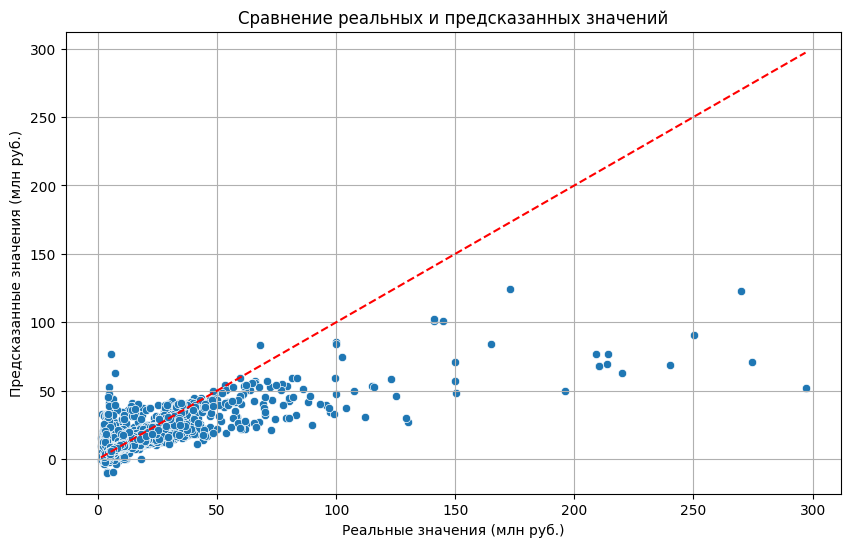

In [ ]:
# Оценка работы модели
evaluate_model(model, X_test, y_test, scaler_price, mean_price)

## **3. Метод K-ближайших соседей (K-Nearest Neighbors, KNN)**

Метод K-ближайших соседей (KNN) - это простой и эффективный алгоритм машинного обучения для задач классификации и регрессии. Он основывается на предположении, что объекты, которые находятся близко друг к другу в пространстве признаков, вероятно, имеют схожие значения целевой переменной.

### **Теория**

Основная идея метода K-ближайших соседей для задачи регрессии заключается в следующем:

1. **Обучение:** Метод KNN не имеет явного этапа обучения. Вместо этого он запоминает все тренировочные данные.
2. **Регрессия:** Для предсказания значения целевой переменной для нового объекта метод KNN находит K ближайших соседей в тренировочном наборе данных и рассчитывает среднее значение целевой переменной этих соседей. Это среднее значение и является предсказанием для нового объекта.




**Пример**

У нас есть таблица с данными о фруктах, включающая такие признаки, как вес, цвет и цена. Мы хотим предсказать цену фрукта на основе его веса и цвета.

Исходная таблица:

| Вес (г) | Цвет       | Цена (руб) |
|---------|------------|------------|
| 150     | Красный    | 30         |
| 180     | Зеленый    | 35         |
| 200     | Желтый     | 40         |
| 170     | Красный    | 32         |
| 120     | Зеленый    | 25         |
| 190     | Желтый     | 38         |

Преобразование данных

Для того чтобы алгоритм K-ближайших соседей мог работать с нашими данными, нам нужно преобразовать категориальные признаки (цвет) в числовые. Например, мы можем использовать следующие кодировки:

- Цвет:
  - Красный: 1
  - Зеленый: 2
  - Желтый: 3

После преобразования наша таблица будет выглядеть так:

| Вес (г) | Цвет | Цена (руб) |
|---------|------|------------|
| 150     | 1    | 30         |
| 180     | 2    | 35         |
| 200     | 3    | 40         |
| 170     | 1    | 32         |
| 120     | 2    | 25         |
| 190     | 3    | 38         |

Предсказание цены нового фрукта

Теперь предположим, что у нас есть новый фрукт с весом 175 г и цветом 2 (зеленый), и мы хотим предсказать его цену с помощью метода K-ближайших соседей.

**1. Рассчитываем расстояния**

Для каждого объекта в тренировочной выборке рассчитываем расстояние до нового объекта.

Пример расчета для первого объекта (150 г, красный (1)):

1. Разница в весе: 175 - 150 = 25
2. Разница в цвете: 2 - 1 = 1
3. Итоговое расстояние: корень квадратный из (25 в квадрате + 1 в квадрате) = корень квадратный из (625 + 1) = корень квадратный из 626 ≈ 25.02

Повторяем этот расчет для всех остальных объектов.

**2. Находим K ближайших соседей**

Пусть K = 3. Выбираем три объекта с наименьшими расстояниями.

**3. Предсказываем цену нового объекта**

Среди трех ближайших соседей значения цен следующие: 35 руб, 32 руб, и 38 руб.

Предсказанная цена нового объекта будет средним значением этих цен:

(35 + 32 + 38) / 3 = 35 руб

Используя метод K-ближайших соседей, мы смогли предсказать цену нового фрукта на основе его веса и цвета, сравнив его с ближайшими соседями в тренировочной выборке. Этот метод является простым и эффективным способом регрессии на основе признаков объекта.




**Преимущества метода K-ближайших соседей:**
- Простота и интерпретируемость.
- Отсутствие этапа обучения, что делает его быстрым для настройки.

**Недостатки метода K-ближайших соседей:**
- Медленное предсказание для больших наборов данных.
- Чувствительность к шуму и выбросам в данных.

### **Практика**

In [ ]:
#@title Загрузка необходимых библиотек (ЗАПУСТИТЕ ЭТОТ КОД)
!pip install gdown
import pandas as pd
import numpy as np
import gdown
import warnings
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from sklearn.feature_extraction.text import CountVectorizer

# Игнорирование предупреждений
warnings.filterwarnings("ignore", category=UserWarning)

# Загрузка и распаковка данных
URL = 'https://storage.yandexcloud.net/terraai/sources/flats.zip'
download_filename = gdown.download(URL, None, quiet=True)
!unzip -q {download_filename} -d '/content/data'
!rm -rf {download_filename}

#@title Загрузка данных
def load_data():
    df = pd.read_csv('/content/data/flats.csv')
    df.drop(columns=['Источник', 'Бонус агенту', 'Дата', 'Кол-во дней в экспозиции'], inplace=True)
    df = df[df['Цена, тыс.руб.'] <= 300_000]
    df = df[df['Комнат'] == 1]
    df.drop(columns=['Комнат'], inplace=True)
    return df

# Очистка вывода
clear_output()

In [ ]:
#@title Сервисные функции (ЗАПУСТИТЕ ЭТОТ КОД)
#@title Преобразование текста в векторы
def text_to_vector(df, column, vector_size):
    vectorizer = CountVectorizer(max_features=vector_size, stop_words='english', token_pattern=r'\b\w+\b')
    text_vectors = vectorizer.fit_transform(df[column].astype('U')).toarray()
    text_vector_df = pd.DataFrame(text_vectors, columns=[f'{column}_vec_{i}' for i in range(vector_size)])
    df = pd.concat([df.reset_index(drop=True), text_vector_df.reset_index(drop=True)], axis=1)
    df.drop(columns=[column], inplace=True)
    return df

# Функция предобработки данных
def preprocess_data(df):
    # Обработка пропущенных значений
    df = df.dropna()

    # Список столбцов для OHE, исключаем 'Этаж' и 'Всего этажей в доме'
    categorical_columns = ['Тип дома', 'Балконы', 'Лоджии', 'Станция метро', 'Пешком или на транспорте', 'Санузел', 'Тип санузла']

    # Применение OHE
    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True, dtype=np.int8)

    # Нормирование столбцов Время в пути, Площадь, Этаж и Всего этажей в доме
    scaler_time = StandardScaler()
    scaler_area = StandardScaler()
    scaler_floor = StandardScaler()
    scaler_total_floors = StandardScaler()

    df[['Время в пути']] = scaler_time.fit_transform(df[['Время в пути']])
    df[['Площадь']] = scaler_area.fit_transform(df[['Площадь']])
    df[['Этаж']] = scaler_floor.fit_transform(df[['Этаж']])
    df[['Всего этажей в доме']] = scaler_total_floors.fit_transform(df[['Всего этажей в доме']])

    # Расчет средней стоимости до нормализации
    mean_price = df['Цена, тыс.руб.'].mean()

    return df, mean_price

#@title Нормирование целевых значений
def normalize_target(df):
    scaler_price = StandardScaler()
    df[['Цена, тыс.руб.']] = scaler_price.fit_transform(df[['Цена, тыс.руб.']])
    return df, scaler_price

#@title Разделение данных
def split_data(df, test_size):
    # Разделение данных на обучающую и тестовую выборки
    X = df.drop('Цена, тыс.руб.', axis=1)
    y = df['Цена, тыс.руб.']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

#@title Обучение модели KNN
def train_knn_model(X_train, y_train, n_neighbors):
    # Создание и обучение модели K-ближайших соседей
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    return knn

#@title Оценка модели
def evaluate_model(model, X_test, y_test, scaler_price, mean_price):
    # Предсказание модели
    y_pred = model.predict(X_test)

    # Обратное преобразование цены для предсказаний и реальных значений
    y_test_actual = scaler_price.inverse_transform(y_test.values.reshape(-1, 1)).flatten()
    y_pred_actual = scaler_price.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    # Расчёт средней абсолютной ошибки в млн рублей
    mae_actual = mean_absolute_error(y_test_actual, y_pred_actual) / 1000

    # Расчёт средней стоимости квартир на всей выборке в млн рублей
    mean_price_actual = mean_price / 1000

    # Расчёт процентной ошибки
    percentage_error = (mae_actual / mean_price_actual) * 100

    print(f'Средняя абсолютная ошибка (MAE): {mae_actual:.2f} млн руб.')
    print(f'Средняя стоимость на всей выборке: {mean_price_actual:.2f} млн руб.')
    print(f'Процентная ошибка: {percentage_error:.2f}%')

    # Вывод таблицы сравнения первых нескольких предсказанных и реальных значений
    comparison = pd.DataFrame({'Предсказанное': y_pred_actual / 1000, 'Реальное': y_test_actual / 1000}).head(10)
    print("Сравнение предсказанных и реальных значений:")
    print(comparison)

    # Построение графика предсказанных и реальных значений
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test_actual / 1000, y=y_pred_actual / 1000)
    plt.plot([y_test_actual.min() / 1000, y_test_actual.max() / 1000], [y_test_actual.min() / 1000, y_test_actual.max() / 1000], 'r--')
    plt.xlabel('Реальные значения (млн руб.)')
    plt.ylabel('Предсказанные значения (млн руб.)')
    plt.title('Сравнение реальных и предсказанных значений')
    plt.grid(True)
    plt.show()

def find_optimal_k(X_train, y_train, neighbor_range):
    """
    Функция для подбора оптимального значения параметра n_neighbors для K-ближайших соседей.

    Параметры:
    X_train (pd.DataFrame или np.ndarray): Признаки обучающей выборки.
    y_train (pd.Series или np.ndarray): Целевые метки обучающей выборки.
    neighbor_range (range): Диапазон значений для параметра n_neighbors.

    Возвращает:
    int: Оптимальное значение n_neighbors.
    """
    cv_scores = []

    # Проведение кросс-валидации для каждого значения n_neighbors
    for n in neighbor_range:
        knn = KNeighborsRegressor(n_neighbors=n)
        # cv=5 означает 5-кратную кросс-валидацию
        scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
        cv_scores.append(-scores.mean())  # берем модуль, чтобы сделать значение положительным

    # Определение оптимального значения n_neighbors
    optimal_n = neighbor_range[cv_scores.index(min(cv_scores))]
    print(f'Оптимальное количество соседей: {optimal_n}')

    # Построение графика точности для различных значений n_neighbors
    plt.figure(figsize=(10, 6))
    plt.plot(neighbor_range, cv_scores, marker='o')
    plt.xlabel('Количество соседей K')
    plt.ylabel('Средняя абсолютная ошибка (MAE)')
    plt.title('MAE в зависимости от количества соседей K')
    plt.grid(True)
    plt.show()

    return optimal_n

In [ ]:
# Загружаем данные
df = load_data()
df

,Станция метро,Время в пути,Пешком или на транспорте,Этаж,Всего этажей в доме,Тип дома,Балконы,Лоджии,Санузел,Тип санузла,Площадь,"Цена, тыс.руб.",Примечание
0,Шелепиха м.,12,Пешком,35,37,Монолитный,0,0,2,Не указано,64.1,19500.00,Собственность оформлена! Ключи на руках! Опера...
1,Пятницкое шоссе м.,30,На транспорте,11,14,Панельный,0,1,1,Раздельный,38.4,4800.00,Зеленоград к.1820 однокомнатная квартира общ.3...
2,Планерная м.,5,На транспорте,11,22,Панельный,1,0,1,Совмещенный,38.2,7990.00,"Уютная, светлая квартира, застекленный балкон ..."
3,Шаболовская м.,12,Пешком,8,12,Не указано,1,0,1,Раздельный,38.0,11200.00,"Предлагаю 1- комн квартиру, в шаговой доступно..."
4,Бабушкинская м.,15,Пешком,4,14,Панельный,0,0,1,Совмещенный,34.0,6250.00,Продается хорошая 1 комнатная квартира. 1 взро...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
126263,Некрасовка м.,4,Пешком,2,17,Панельный,0,0,1,Не указано,19.8,2850.00,Уникальнейшее предложение! 7 минуты до метро! ...
126264,Авиамоторная м.,6,Пешком,2,8,Кирпичный,0,0,1,Совмещенный,20.4,3839.99,ВЫГОДНОЕ ПРЕДЛОЖЕНИЕ в пешей доступности от ме...
126265,Коломенская м.,15,Пешком,1,9,Панельный,0,0,1,Не указано,15.4,2900.00,СТУДИЯ В МОСКВЕ ПО ДОСТУПНОЙ ЦЕНЕ ! __________...
126266,Алтуфьево м.,5,На транспорте,4,9,Монолитный,0,0,1,Не указано,26.0,5200.00,Продается студия с отделкой в новом монолитном...


In [ ]:
# Предобработка данных и расчет средней стоимости
df, mean_price = preprocess_data(df)
# Нормирование целевых значений
df, scaler_price = normalize_target(df)
df

,Время в пути,Этаж,Всего этажей в доме,Площадь,"Цена, тыс.руб.",Примечание,Тип дома_Деревянный,Тип дома_Железо-бетонный,Тип дома_Кирпичный,Тип дома_Монолитный,...,Станция метро_Южная м.,Станция метро_Ясенево м.,Пешком или на транспорте_Не указано,Пешком или на транспорте_Пешком,Санузел_1,Санузел_2,Санузел_3,Санузел_4,Тип санузла_Раздельный,Тип санузла_Совмещенный
0,0.325092,2.856728,1.718539,1.132717,1.080862,Собственность оформлена! Ключи на руках! Опера...,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
1,2.726350,0.117504,-0.419261,-0.118080,-0.418863,Зеленоград к.1820 однокомнатная квартира общ.3...,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,-0.608731,0.117504,0.324321,-0.127814,-0.093412,"Уютная, светлая квартира, застекленный балкон ...",0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0.325092,-0.224899,-0.605157,-0.137547,0.234079,"Предлагаю 1- комн квартиру, в шаговой доступно...",0,0,0,0,...,0,0,0,1,1,0,0,0,1,0
4,0.725301,-0.681436,-0.419261,-0.332224,-0.270931,Продается хорошая 1 комнатная квартира. 1 взро...,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126263,-0.742134,-0.909705,-0.140418,-1.023325,-0.617806,Уникальнейшее предложение! 7 минуты до метро! ...,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
126264,-0.475328,-0.909705,-0.976948,-0.994124,-0.516805,ВЫГОДНОЕ ПРЕДЛОЖЕНИЕ в пешей доступности от ме...,0,0,1,0,...,0,0,0,1,1,0,0,0,0,1
126265,0.725301,-1.023839,-0.884000,-1.237470,-0.612704,СТУДИЯ В МОСКВЕ ПО ДОСТУПНОЙ ЦЕНЕ ! __________...,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
126266,-0.608731,-0.681436,-0.884000,-0.721577,-0.378054,Продается студия с отделкой в новом монолитном...,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
# Преобразование текста в векторы
df = text_to_vector(df, 'Примечание', vector_size=500)
df

,Время в пути,Этаж,Всего этажей в доме,Площадь,"Цена, тыс.руб.",Тип дома_Деревянный,Тип дома_Железо-бетонный,Тип дома_Кирпичный,Тип дома_Монолитный,Тип дома_Не указано,...,Примечание_vec_490,Примечание_vec_491,Примечание_vec_492,Примечание_vec_493,Примечание_vec_494,Примечание_vec_495,Примечание_vec_496,Примечание_vec_497,Примечание_vec_498,Примечание_vec_499
0,0.325092,2.856728,1.718539,1.132717,1.080862,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,2.726350,0.117504,-0.419261,-0.118080,-0.418863,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.608731,0.117504,0.324321,-0.127814,-0.093412,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.325092,-0.224899,-0.605157,-0.137547,0.234079,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0.725301,-0.681436,-0.419261,-0.332224,-0.270931,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74649,-0.742134,-0.909705,-0.140418,-1.023325,-0.617806,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
74650,-0.475328,-0.909705,-0.976948,-0.994124,-0.516805,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
74651,0.725301,-1.023839,-0.884000,-1.237470,-0.612704,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74652,-0.608731,-0.681436,-0.884000,-0.721577,-0.378054,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df # Разделение выборок на обучающую и тестовую
X_train, X_test, y_train, y_test = split_data(df, test_size=0.2)

# Вывод форм выборок
print(f'Форма X_train: {X_train.shape}')
print(f'Форма X_test: {X_test.shape}')
print(f'Форма y_train: {y_train.shape}')
print(f'Форма y_test: {y_test.shape}')

Форма X_train: (59723, 791)
Форма X_test: (14931, 791)
Форма y_train: (59723,)
Форма y_test: (14931,)


Оптимальное количество соседей: 1


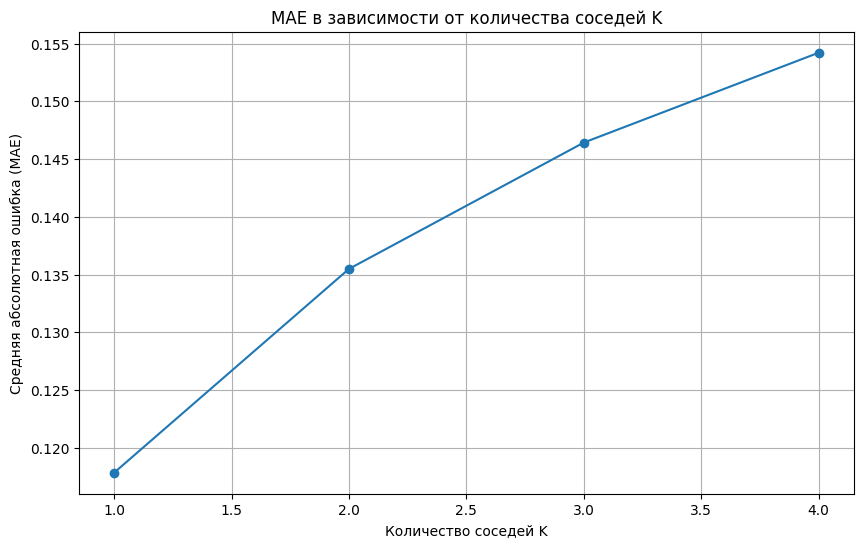

In [ ]:
# Определение оптимального количества соседей
neighbor_range = range(1, 5)
optimal_k = find_optimal_k(X_train, y_train, neighbor_range)

In [ ]:
# Обучение модели
model = train_knn_model(X_train, y_train, n_neighbors=optimal_k)

Средняя абсолютная ошибка (MAE): 1.02 млн руб.
Средняя стоимость на всей выборке: 8.91 млн руб.
Процентная ошибка: 11.48%
Сравнение предсказанных и реальных значений:
   Предсказанное   Реальное
0      17.467563  13.000000
1       6.800000   9.400000
2      13.000000   9.300000
3       7.100000   7.100000
4      10.584420  10.326400
5       8.400000   6.999999
6       7.100000   5.100000
7       7.490000   7.490000
8       2.700000   2.900000
9       5.501600   5.501600


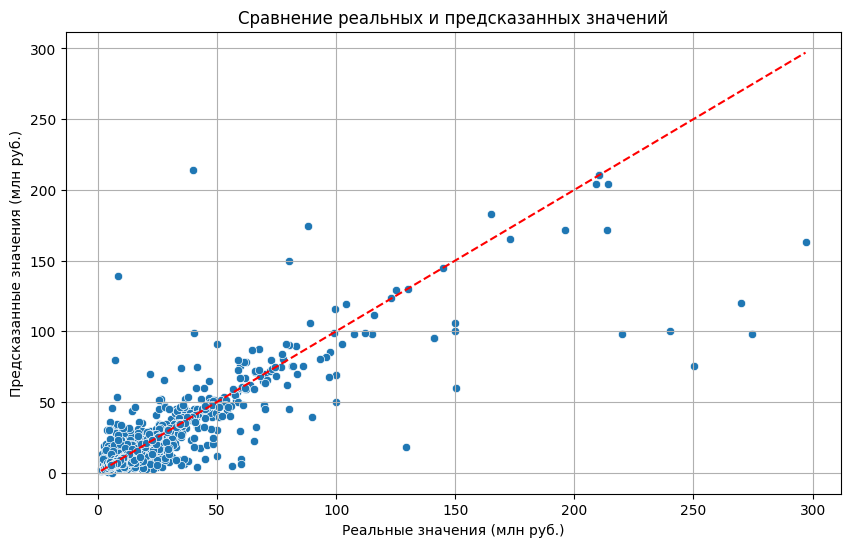

In [ ]:
# Оценка работы модели
evaluate_model(model, X_test, y_test, scaler_price, mean_price)

## **4. Байесовская линейная регрессия (Naive Bayes for Regression)**

Байесовская линейная регрессия - это метод, основанный на байесовской статистике для предсказания непрерывных значений. В отличие от наивного байесовского классификатора, который предсказывает классы, байесовская линейная регрессия предсказывает непрерывные переменные. Принцип работы включает в себя использование вероятностных моделей для предсказания целевой переменной на основе входных признаков.

### **Теория**

Байесовская линейная регрессия - это метод, основанный на байесовской статистике для предсказания непрерывных значений. В отличие от наивного байесовского классификатора, который предсказывает классы, байесовская линейная регрессия предсказывает непрерывные переменные. Принцип работы включает в себя использование вероятностных моделей для предсказания целевой переменной на основе входных признаков.

Основная идея байесовской линейной регрессии заключается в следующем:

1. **Теорема Байеса:** Используется для вычисления условной вероятности целевой переменной на основе признаков.
2. **Наивное предположение:** Предполагается, что все признаки независимы друг от друга, что редко выполняется в реальных данных, но метод все равно показывает хорошие результаты. Это упрощает вычисление апостериорных вероятностей.
3. **Регрессия:** Предсказывается значение целевой переменной, которое максимизирует условную вероятность. Используется линейная модель, где параметры модели оцениваются с использованием байесовских методов.

Байесовская линейная регрессия позволяет учитывать неопределенность в предсказаниях и использовать априорные знания для улучшения модели, что делает ее мощным инструментом для задач регрессии.



**Пример:**

Предположим, у нас есть таблица с данными о квартирах, включающая такие признаки, как площадь, тип дома и цена квартиры. Мы хотим предсказать цену квартиры на основе этих признаков.

**Исходная таблица:**

| Площадь (м²) | Тип дома     | Цена (тыс. руб.) |
|--------------|--------------|------------------|
| 50           | Кирпичный    | 3000             |
| 60           | Панельный    | 3500             |
| 45           | Кирпичный    | 2800             |
| 70           | Монолитный   | 4000             |
| 55           | Панельный    | 3200             |
| 65           | Кирпичный    | 3600             |

Преобразование данных:

Для того чтобы байесовская регрессия могла работать с нашими данными, нам нужно преобразовать категориальные признаки (тип дома) в числовые. Например, мы можем использовать следующие кодировки:

- Тип дома:
  - Кирпичный: 1
  - Панельный: 2
  - Монолитный: 3

После преобразования наша таблица будет выглядеть так:

| Площадь (м²) | Тип дома | Цена (тыс. руб.) |
|--------------|----------|------------------|
| 50           | 1        | 3000             |
| 60           | 2        | 3500             |
| 45           | 1        | 2800             |
| 70           | 3        | 4000             |
| 55           | 2        | 3200             |
| 65           | 1        | 3600             |

Пример расчета:

Для новой квартиры с площадью 58 м² и типом дома 2 (панельный), байесовская линейная регрессия предскажет ее цену, используя условные вероятности.

Итог:

Таким образом, для квартиры с площадью 58 м² и панельным типом дома байесовская линейная регрессия предскажет цену, используя условные вероятности.



**Преимущества наивного байесовского регрессора:**
- Простота и интерпретируемость.
- Быстрое обучение и предсказание.
- Эффективен для больших объемов данных.

**Недостатки наивного байесовского регрессора:**
- Предположение о независимости признаков редко выполняется в реальных данных.
- Чувствительность к редким признакам и классовым дисбалансам.


### **Практика**

In [ ]:
#@title Загрузка необходимых библиотек
import pandas as pd
import numpy as np
import gdown
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import statsmodels.api as sm
from sklearn.feature_extraction.text import CountVectorizer

URL = 'https://storage.yandexcloud.net/terraai/sources/flats.zip'
download_filename = gdown.download(URL, None, quiet=True)
!unzip -q {download_filename} -d '/content/data'
!rm -rf {download_filename}

# Игнорирование предупреждений
warnings.filterwarnings("ignore", category=UserWarning)

#@title Загрузка данных
def load_data():
    df = pd.read_csv('/content/data/flats.csv')
    df.drop(columns=['Источник', 'Бонус агенту', 'Дата', 'Кол-во дней в экспозиции'], inplace=True)
    df = df[df['Цена, тыс.руб.'] <= 300_000]
    df = df[df['Комнат'] == 1]
    df.drop(columns=['Комнат'], inplace=True)
    return df

# Очистка вывода
clear_output()

In [ ]:
#@title Сервисные функции (ЗАПУСТИТЕ ЭТОТ КОД)
#@title Преобразование текста в векторы
def text_to_vector(df, column, vector_size):
    vectorizer = CountVectorizer(max_features=vector_size, stop_words='english', token_pattern=r'\b\w+\b')
    text_vectors = vectorizer.fit_transform(df[column].astype('U')).toarray()
    text_vector_df = pd.DataFrame(text_vectors, columns=[f'{column}_vec_{i}' for i in range(vector_size)])
    df = pd.concat([df.reset_index(drop=True), text_vector_df.reset_index(drop=True)], axis=1)
    df.drop(columns=[column], inplace=True)
    return df

# Функция предобработки данных
def preprocess_data(df):
    # Обработка пропущенных значений
    df = df.dropna()

    # Список столбцов для OHE, исключаем 'Этаж' и 'Всего этажей в доме'
    categorical_columns = ['Тип дома', 'Балконы', 'Лоджии', 'Станция метро', 'Пешком или на транспорте', 'Санузел', 'Тип санузла']

    # Применение OHE
    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True, dtype=np.int8)

    # Нормирование столбцов Время в пути, Площадь, Этаж и Всего этажей в доме
    scaler_time = StandardScaler()
    scaler_area = StandardScaler()
    scaler_floor = StandardScaler()
    scaler_total_floors = StandardScaler()

    df[['Время в пути']] = scaler_time.fit_transform(df[['Время в пути']])
    df[['Площадь']] = scaler_area.fit_transform(df[['Площадь']])
    df[['Этаж']] = scaler_floor.fit_transform(df[['Этаж']])
    df[['Всего этажей в доме']] = scaler_total_floors.fit_transform(df[['Всего этажей в доме']])

    # Расчет средней стоимости до нормализации
    mean_price = df['Цена, тыс.руб.'].mean()

    return df, mean_price

#@title Нормирование целевых значений
def normalize_target(df):
    scaler_price = StandardScaler()
    df[['Цена, тыс.руб.']] = scaler_price.fit_transform(df[['Цена, тыс.руб.']])
    return df, scaler_price

#@title Разделение данных
def split_data(df, test_size):
    # Разделение данных на обучающую и тестовую выборки
    X = df.drop('Цена, тыс.руб.', axis=1)
    y = df['Цена, тыс.руб.']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

#@title Обучение модели Bayesian Ridge Regression
def train_bayesian_model(X_train, y_train):
    # Добавляем константу для интерсепта
    X_train_const = sm.add_constant(X_train)

    # Создание и обучение модели байесовской линейной регрессии
    model = sm.OLS(y_train, X_train_const).fit()
    return model

#@title Оценка модели
def evaluate_model(model, X_test, y_test, scaler_price, mean_price):
    # Добавляем константу для интерсепта
    X_test_const = sm.add_constant(X_test)

    # Предсказание модели
    y_pred = model.predict(X_test_const)

    # Обратное преобразование цены для предсказаний и реальных значений
    y_test_actual = scaler_price.inverse_transform(y_test.values.reshape(-1, 1)).flatten()
    y_pred_actual = scaler_price.inverse_transform(y_pred.values.reshape(-1, 1)).flatten()

    # Расчёт средней абсолютной ошибки в млн рублей
    mae_actual = mean_absolute_error(y_test_actual, y_pred_actual) / 1000

    # Расчёт средней стоимости квартир на всей выборке в млн рублей
    mean_price_actual = mean_price / 1000

    # Расчёт процентной ошибки
    percentage_error = (mae_actual / mean_price_actual) * 100

    print(f'Средняя абсолютная ошибка (MAE): {mae_actual:.2f} млн руб.')
    print(f'Средняя стоимость на всей выборке: {mean_price_actual:.2f} млн руб.')
    print(f'Процентная ошибка: {percentage_error:.2f}%')

    # Вывод таблицы сравнения первых нескольких предсказанных и реальных значений
    comparison = pd.DataFrame({'Предсказанное': y_pred_actual / 1000, 'Реальное': y_test_actual / 1000}).head(10)
    print("Сравнение предсказанных и реальных значений:")
    print(comparison)

    # Построение графика предсказанных и реальных значений
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test_actual / 1000, y=y_pred_actual / 1000)
    plt.plot([y_test_actual.min() / 1000, y_test_actual.max() / 1000], [y_test_actual.min() / 1000, y_test_actual.max() / 1000], 'r--')
    plt.xlabel('Реальные значения (млн руб.)')
    plt.ylabel('Предсказанные значения (млн руб.)')
    plt.title('Сравнение реальных и предсказанных значений')
    plt.grid(True)
    plt.show()

In [ ]:
# Загружаем данные
df = load_data()
df

,Станция метро,Время в пути,Пешком или на транспорте,Этаж,Всего этажей в доме,Тип дома,Балконы,Лоджии,Санузел,Тип санузла,Площадь,"Цена, тыс.руб.",Примечание
0,Шелепиха м.,12,Пешком,35,37,Монолитный,0,0,2,Не указано,64.1,19500.00,Собственность оформлена! Ключи на руках! Опера...
1,Пятницкое шоссе м.,30,На транспорте,11,14,Панельный,0,1,1,Раздельный,38.4,4800.00,Зеленоград к.1820 однокомнатная квартира общ.3...
2,Планерная м.,5,На транспорте,11,22,Панельный,1,0,1,Совмещенный,38.2,7990.00,"Уютная, светлая квартира, застекленный балкон ..."
3,Шаболовская м.,12,Пешком,8,12,Не указано,1,0,1,Раздельный,38.0,11200.00,"Предлагаю 1- комн квартиру, в шаговой доступно..."
4,Бабушкинская м.,15,Пешком,4,14,Панельный,0,0,1,Совмещенный,34.0,6250.00,Продается хорошая 1 комнатная квартира. 1 взро...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
126263,Некрасовка м.,4,Пешком,2,17,Панельный,0,0,1,Не указано,19.8,2850.00,Уникальнейшее предложение! 7 минуты до метро! ...
126264,Авиамоторная м.,6,Пешком,2,8,Кирпичный,0,0,1,Совмещенный,20.4,3839.99,ВЫГОДНОЕ ПРЕДЛОЖЕНИЕ в пешей доступности от ме...
126265,Коломенская м.,15,Пешком,1,9,Панельный,0,0,1,Не указано,15.4,2900.00,СТУДИЯ В МОСКВЕ ПО ДОСТУПНОЙ ЦЕНЕ ! __________...
126266,Алтуфьево м.,5,На транспорте,4,9,Монолитный,0,0,1,Не указано,26.0,5200.00,Продается студия с отделкой в новом монолитном...


In [ ]:
# Предобработка данных и расчет средней стоимости
df, mean_price = preprocess_data(df)
# Нормирование целевых значений
df, scaler_price = normalize_target(df)
df

,Время в пути,Этаж,Всего этажей в доме,Площадь,"Цена, тыс.руб.",Примечание,Тип дома_Деревянный,Тип дома_Железо-бетонный,Тип дома_Кирпичный,Тип дома_Монолитный,...,Станция метро_Южная м.,Станция метро_Ясенево м.,Пешком или на транспорте_Не указано,Пешком или на транспорте_Пешком,Санузел_1,Санузел_2,Санузел_3,Санузел_4,Тип санузла_Раздельный,Тип санузла_Совмещенный
0,0.325092,2.856728,1.718539,1.132717,1.080862,Собственность оформлена! Ключи на руках! Опера...,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
1,2.726350,0.117504,-0.419261,-0.118080,-0.418863,Зеленоград к.1820 однокомнатная квартира общ.3...,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,-0.608731,0.117504,0.324321,-0.127814,-0.093412,"Уютная, светлая квартира, застекленный балкон ...",0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0.325092,-0.224899,-0.605157,-0.137547,0.234079,"Предлагаю 1- комн квартиру, в шаговой доступно...",0,0,0,0,...,0,0,0,1,1,0,0,0,1,0
4,0.725301,-0.681436,-0.419261,-0.332224,-0.270931,Продается хорошая 1 комнатная квартира. 1 взро...,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126263,-0.742134,-0.909705,-0.140418,-1.023325,-0.617806,Уникальнейшее предложение! 7 минуты до метро! ...,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
126264,-0.475328,-0.909705,-0.976948,-0.994124,-0.516805,ВЫГОДНОЕ ПРЕДЛОЖЕНИЕ в пешей доступности от ме...,0,0,1,0,...,0,0,0,1,1,0,0,0,0,1
126265,0.725301,-1.023839,-0.884000,-1.237470,-0.612704,СТУДИЯ В МОСКВЕ ПО ДОСТУПНОЙ ЦЕНЕ ! __________...,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
126266,-0.608731,-0.681436,-0.884000,-0.721577,-0.378054,Продается студия с отделкой в новом монолитном...,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
# Преобразование текста в векторы
df = text_to_vector(df, 'Примечание', vector_size=500)
df

,Время в пути,Этаж,Всего этажей в доме,Площадь,"Цена, тыс.руб.",Тип дома_Деревянный,Тип дома_Железо-бетонный,Тип дома_Кирпичный,Тип дома_Монолитный,Тип дома_Не указано,...,Примечание_vec_490,Примечание_vec_491,Примечание_vec_492,Примечание_vec_493,Примечание_vec_494,Примечание_vec_495,Примечание_vec_496,Примечание_vec_497,Примечание_vec_498,Примечание_vec_499
0,0.325092,2.856728,1.718539,1.132717,1.080862,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,2.726350,0.117504,-0.419261,-0.118080,-0.418863,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.608731,0.117504,0.324321,-0.127814,-0.093412,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.325092,-0.224899,-0.605157,-0.137547,0.234079,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0.725301,-0.681436,-0.419261,-0.332224,-0.270931,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74649,-0.742134,-0.909705,-0.140418,-1.023325,-0.617806,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
74650,-0.475328,-0.909705,-0.976948,-0.994124,-0.516805,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
74651,0.725301,-1.023839,-0.884000,-1.237470,-0.612704,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74652,-0.608731,-0.681436,-0.884000,-0.721577,-0.378054,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df # Разделение выборок на обучающую и тестовую
X_train, X_test, y_train, y_test = split_data(df, test_size=0.2)

# Вывод форм выборок
print(f'Форма X_train: {X_train.shape}')
print(f'Форма X_test: {X_test.shape}')
print(f'Форма y_train: {y_train.shape}')
print(f'Форма y_test: {y_test.shape}')

Форма X_train: (59723, 791)
Форма X_test: (14931, 791)
Форма y_train: (59723,)
Форма y_test: (14931,)


In [ ]:
# Обучение модели
model = train_bayesian_model(X_train, y_train)

Средняя абсолютная ошибка (MAE): 2.46 млн руб.
Средняя стоимость на всей выборке: 8.91 млн руб.
Процентная ошибка: 27.59%
Сравнение предсказанных и реальных значений:
   Предсказанное   Реальное
0      14.728325  13.000000
1      11.670127   9.400000
2      10.844020   9.300000
3       8.251121   7.100000
4      12.610250  10.326400
5       8.096401   6.999999
6       5.716549   5.100000
7       9.167113   7.490000
8      -4.742911   2.900000
9       5.989914   5.501600


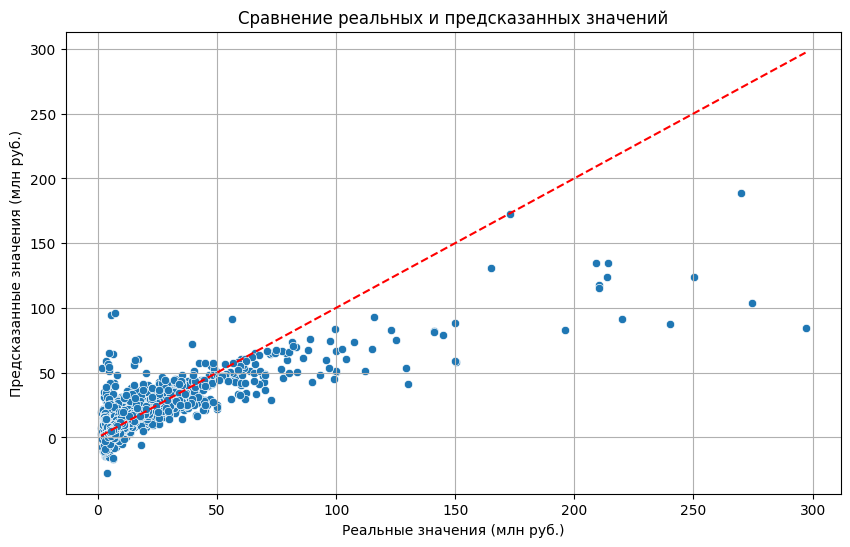

In [ ]:
# Оценка работы модели
evaluate_model(model, X_test, y_test, scaler_price, mean_price)

## **5. Градиентный бустинг (Gradient Boosting)**

Градиентный бустинг - это мощный ансамблевый метод машинного обучения, который используется для задач регрессии и классификации. Он строит модель предсказания в виде ансамбля слабых моделей, обычно деревьев решений. Каждое последующее дерево пытается исправить ошибки предыдущих деревьев, минимизируя функцию потерь.

### **Теория**

Градиентный бустинг - это мощный ансамблевый метод машинного обучения, который используется для задач регрессии и классификации. Он строит модель предсказания в виде ансамбля слабых моделей, обычно деревьев решений. Каждое последующее дерево пытается исправить ошибки предыдущих деревьев, минимизируя функцию потерь.

Основная идея градиентного бустинга заключается в следующем:

1. **Инициализация модели:** На первом шаге создается начальная модель, обычно простое дерево решений или даже просто константа, которая предсказывает среднее значение целевой переменной.
2. **Построение последовательных моделей:** На каждом следующем шаге строится новое дерево решений, которое обучается на остатках (ошибках) предыдущих деревьев. Это дерево добавляется к текущей модели, улучшая ее точность.
3. **Минимизация функции потерь:** Новое дерево обучается таким образом, чтобы минимизировать функцию потерь на текущем наборе данных.

**Пример:**

Предположим, у нас есть небольшая таблица с данными о фруктах, включающая такие признаки, как вес, цвет и тип фрукта. Мы хотим предсказать вес фрукта на основе этих признаков.

| Вес (г) | Цвет       | Тип фрукта |
|---------|------------|------------|
| 150     | Красный    | Яблоко     |
| 180     | Зеленый    | Яблоко     |
| 200     | Желтый     | Банан      |
| 170     | Красный    | Яблоко     |
| 120     | Зеленый    | Яблоко     |
| 190     | Желтый     | Банан      |

Рассмотрим, как градиентный бустинг может построить три дерева для предсказания веса фруктов:

**Инициализация модели:**
- Предположим, начальная модель предсказывает средний вес фруктов. Средний вес = (150 + 180 + 200 + 170 + 120 + 190) / 6 = 168.33 г.

**Дерево 1:**
- Обучается на остатках (разницах между реальными весами и предсказанием средней модели).
- Например, для первого фрукта: остаток = 150 - 168.33 = -18.33 г.
- Если "Цвет" = Желтый, предсказывает +30 г (поправка для увеличения веса).
- Иначе предсказывает -20 г (поправка для уменьшения веса).

**Дерево 2:**
- Обучается на остатках, оставшихся после применения первого дерева.
- Например, для первого фрукта: новый остаток = -18.33 - (-20) = 1.67 г.
- Если "Тип фрукта" = Банан, предсказывает +15 г.
- Иначе предсказывает -10 г.

**Дерево 3:**
- Обучается на остатках, оставшихся после применения второго дерева.
- Например, для первого фрукта: новый остаток = 1.67 - (-10) = 11.67 г.
- Если "Цвет" = Красный, предсказывает +10 г.
- Иначе предсказывает -5 г.

Для нового фрукта с зеленым цветом и типом "Яблоко", предсказания деревьев будут следующими:
- Начальная модель предсказывает 168.33 г.
- Дерево 1 предсказывает -20 г (так как цвет не Желтый).
- Дерево 2 предсказывает -10 г (так как тип не Банан).
- Дерево 3 предсказывает -5 г (так как цвет не Красный).

Градиентный бустинг суммирует эти предсказания:
- Итоговое предсказание = 168.33 + (-20) + (-10) + (-5) = 133.33 г.


**Преимущества градиентного бустинга:**
- Высокая точность предсказаний.
- Хорошо работает с различными типами данных.
- Способен моделировать сложные зависимости.

**Недостатки градиентного бустинга:**
- Длительное время обучения.
- Множество гиперпараметров, требующих настройки.
- Склонность к переобучению при недостаточной регуляризации.

### **Практика**

In [ ]:
#@title Загрузка необходимых библиотек (ЗАПУСТИТЕ ЭТОТ КОД)
import pandas as pd
import numpy as np
import gdown
import warnings
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

URL = 'https://storage.yandexcloud.net/terraai/sources/flats.zip'
download_filename = gdown.download(URL, None, quiet=True)
!unzip -q {download_filename} -d '/content/data'
!rm -rf {download_filename}

# Игнорирование предупреждений
warnings.filterwarnings("ignore", category=UserWarning)

#@title Загрузка данных
def load_data():
    df = pd.read_csv('/content/data/flats.csv')
    df.drop(columns=['Источник', 'Бонус агенту', 'Дата', 'Кол-во дней в экспозиции'], inplace=True)
    df = df[df['Цена, тыс.руб.'] <= 300_000]
    df = df[df['Комнат'] == 1]
    df.drop(columns=['Комнат'], inplace=True)
    return df

# Очистка вывода
clear_output()

In [ ]:
#@title Сервисные функции (ЗАПУСТИТЕ ЭТОТ КОД)
#@title Преобразование текста в векторы
def text_to_vector(df, column, vector_size):
    vectorizer = CountVectorizer(max_features=vector_size, stop_words='english', token_pattern=r'\b\w+\b')
    text_vectors = vectorizer.fit_transform(df[column].astype('U')).toarray()
    text_vector_df = pd.DataFrame(text_vectors, columns=[f'{column}_vec_{i}' for i in range(vector_size)])
    df = pd.concat([df.reset_index(drop=True), text_vector_df.reset_index(drop=True)], axis=1)
    df.drop(columns=[column], inplace=True)
    return df

# Функция предобработки данных
def preprocess_data(df):
    # Обработка пропущенных значений
    df = df.dropna()

    # Список столбцов для OHE, исключаем 'Этаж' и 'Всего этажей в доме'
    categorical_columns = ['Тип дома', 'Балконы', 'Лоджии', 'Станция метро', 'Пешком или на транспорте', 'Санузел', 'Тип санузла']

    # Применение OHE
    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True, dtype=np.int8)

    # Нормирование столбцов Время в пути, Площадь, Этаж и Всего этажей в доме
    scaler_time = StandardScaler()
    scaler_area = StandardScaler()
    scaler_floor = StandardScaler()
    scaler_total_floors = StandardScaler()

    df[['Время в пути']] = scaler_time.fit_transform(df[['Время в пути']])
    df[['Площадь']] = scaler_area.fit_transform(df[['Площадь']])
    df[['Этаж']] = scaler_floor.fit_transform(df[['Этаж']])
    df[['Всего этажей в доме']] = scaler_total_floors.fit_transform(df[['Всего этажей в доме']])

    # Расчет средней стоимости до нормализации
    mean_price = df['Цена, тыс.руб.'].mean()

    return df, mean_price

#@title Нормирование целевых значений
def normalize_target(df):
    scaler_price = StandardScaler()
    df[['Цена, тыс.руб.']] = scaler_price.fit_transform(df[['Цена, тыс.руб.']])
    return df, scaler_price

#@title Разделение данных
def split_data(df, test_size):
    # Разделение данных на обучающую и тестовую выборки
    X = df.drop('Цена, тыс.руб.', axis=1)
    y = df['Цена, тыс.руб.']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

#@title Обучение модели градиентного бустинга
def train_model(X_train, y_train, n_estimators):
    # Создание и обучение модели градиентного бустинга
    gb = GradientBoostingRegressor(n_estimators=n_estimators, random_state=42)
    gb.fit(X_train, y_train)
    return gb

#@title Оценка модели
def evaluate_model(model, X_test, y_test, scaler_price, mean_price):
    # Предсказание и оценка модели
    y_pred = model.predict(X_test)

    # Обратное преобразование нормализованных значений
    y_test_orig = scaler_price.inverse_transform(y_test.values.reshape(-1, 1)).flatten()
    y_pred_orig = scaler_price.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    mae = mean_absolute_error(y_test_orig, y_pred_orig) / 1000  # Преобразуем в млн руб

    # Преобразуем среднюю стоимость в млн руб
    mean_price_mln = mean_price / 1000

    # Расчет процентной ошибки
    percentage_error = (mae / mean_price_mln) * 100

    print(f'Средняя абсолютная ошибка (MAE): {mae:.2f} млн руб.')
    print(f'Средняя стоимость на всей выборке: {mean_price_mln:.2f} млн руб.')
    print(f'Процентная ошибка: {percentage_error:.2f}%')

    # Вывод первых нескольких предсказанных и реальных значений
    comparison = pd.DataFrame({'Предсказанное': y_pred_orig / 1000, 'Реальное': y_test_orig / 1000}).head(10)  # Преобразуем в млн руб
    print("Сравнение предсказанных и реальных значений:")
    print(comparison)

    # Построение графика предсказанных и реальных значений
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test_orig / 1000, y=y_pred_orig / 1000)  # Преобразуем в млн руб
    plt.plot([y_test_orig.min() / 1000, y_test_orig.max() / 1000], [y_test_orig.min() / 1000, y_test_orig.max() / 1000], 'r--')  # Преобразуем в млн руб
    plt.xlabel('Реальные значения (млн руб.)')
    plt.ylabel('Предсказанные значения (млн руб.)')
    plt.title('Сравнение реальных и предсказанных значений')
    plt.grid(True)
    plt.show()

In [ ]:
# Загружаем данные
df = load_data()
df

,Станция метро,Время в пути,Пешком или на транспорте,Этаж,Всего этажей в доме,Тип дома,Балконы,Лоджии,Санузел,Тип санузла,Площадь,"Цена, тыс.руб.",Примечание
0,Шелепиха м.,12,Пешком,35,37,Монолитный,0,0,2,Не указано,64.1,19500.00,Собственность оформлена! Ключи на руках! Опера...
1,Пятницкое шоссе м.,30,На транспорте,11,14,Панельный,0,1,1,Раздельный,38.4,4800.00,Зеленоград к.1820 однокомнатная квартира общ.3...
2,Планерная м.,5,На транспорте,11,22,Панельный,1,0,1,Совмещенный,38.2,7990.00,"Уютная, светлая квартира, застекленный балкон ..."
3,Шаболовская м.,12,Пешком,8,12,Не указано,1,0,1,Раздельный,38.0,11200.00,"Предлагаю 1- комн квартиру, в шаговой доступно..."
4,Бабушкинская м.,15,Пешком,4,14,Панельный,0,0,1,Совмещенный,34.0,6250.00,Продается хорошая 1 комнатная квартира. 1 взро...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
126263,Некрасовка м.,4,Пешком,2,17,Панельный,0,0,1,Не указано,19.8,2850.00,Уникальнейшее предложение! 7 минуты до метро! ...
126264,Авиамоторная м.,6,Пешком,2,8,Кирпичный,0,0,1,Совмещенный,20.4,3839.99,ВЫГОДНОЕ ПРЕДЛОЖЕНИЕ в пешей доступности от ме...
126265,Коломенская м.,15,Пешком,1,9,Панельный,0,0,1,Не указано,15.4,2900.00,СТУДИЯ В МОСКВЕ ПО ДОСТУПНОЙ ЦЕНЕ ! __________...
126266,Алтуфьево м.,5,На транспорте,4,9,Монолитный,0,0,1,Не указано,26.0,5200.00,Продается студия с отделкой в новом монолитном...


In [ ]:
# Преобразование текста в векторы
df = text_to_vector(df, 'Примечание', vector_size=500)
df

,Станция метро,Время в пути,Пешком или на транспорте,Этаж,Всего этажей в доме,Тип дома,Балконы,Лоджии,Санузел,Тип санузла,...,Примечание_vec_490,Примечание_vec_491,Примечание_vec_492,Примечание_vec_493,Примечание_vec_494,Примечание_vec_495,Примечание_vec_496,Примечание_vec_497,Примечание_vec_498,Примечание_vec_499
0,Шелепиха м.,12,Пешком,35,37,Монолитный,0,0,2,Не указано,...,0,0,0,0,0,0,0,0,1,0
1,Пятницкое шоссе м.,30,На транспорте,11,14,Панельный,0,1,1,Раздельный,...,0,0,0,0,0,0,0,0,0,0
2,Планерная м.,5,На транспорте,11,22,Панельный,1,0,1,Совмещенный,...,0,0,0,0,0,0,0,0,0,0
3,Шаболовская м.,12,Пешком,8,12,Не указано,1,0,1,Раздельный,...,0,0,0,0,0,0,0,0,0,0
4,Бабушкинская м.,15,Пешком,4,14,Панельный,0,0,1,Совмещенный,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74649,Некрасовка м.,4,Пешком,2,17,Панельный,0,0,1,Не указано,...,0,0,0,0,0,0,0,0,1,0
74650,Авиамоторная м.,6,Пешком,2,8,Кирпичный,0,0,1,Совмещенный,...,0,0,0,0,0,0,0,0,0,0
74651,Коломенская м.,15,Пешком,1,9,Панельный,0,0,1,Не указано,...,0,0,0,0,0,0,0,0,0,0
74652,Алтуфьево м.,5,На транспорте,4,9,Монолитный,0,0,1,Не указано,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Предобработка данных и расчет средней стоимости
df, mean_price = preprocess_data(df)

# Нормирование целевых значений
df, scaler_price = normalize_target(df)
df

,Время в пути,Этаж,Всего этажей в доме,Площадь,"Цена, тыс.руб.",Примечание_vec_0,Примечание_vec_1,Примечание_vec_2,Примечание_vec_3,Примечание_vec_4,...,Станция метро_Южная м.,Станция метро_Ясенево м.,Пешком или на транспорте_Не указано,Пешком или на транспорте_Пешком,Санузел_1,Санузел_2,Санузел_3,Санузел_4,Тип санузла_Раздельный,Тип санузла_Совмещенный
0,0.325092,2.856728,1.718539,1.132717,1.080862,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
1,2.726350,0.117504,-0.419261,-0.118080,-0.418863,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
2,-0.608731,0.117504,0.324321,-0.127814,-0.093412,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0.325092,-0.224899,-0.605157,-0.137547,0.234079,0,0,1,0,0,...,0,0,0,1,1,0,0,0,1,0
4,0.725301,-0.681436,-0.419261,-0.332224,-0.270931,0,0,2,0,0,...,0,0,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74649,-0.742134,-0.909705,-0.140418,-1.023325,-0.617806,0,0,1,0,0,...,0,0,0,1,1,0,0,0,0,0
74650,-0.475328,-0.909705,-0.976948,-0.994124,-0.516805,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
74651,0.725301,-1.023839,-0.884000,-1.237470,-0.612704,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
74652,-0.608731,-0.681436,-0.884000,-0.721577,-0.378054,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
# Разделение выборок на обучающую и тестовую
X_train, X_test, y_train, y_test = split_data(df, test_size=0.2)

# Вывод форм выборок
print(f'Форма X_train: {X_train.shape}')
print(f'Форма X_test: {X_test.shape}')
print(f'Форма y_train: {y_train.shape}')
print(f'Форма y_test: {y_test.shape}')

Форма X_train: (59723, 791)
Форма X_test: (14931, 791)
Форма y_train: (59723,)
Форма y_test: (14931,)


In [ ]:
# Обучение модели
model = train_model(X_train, y_train, n_estimators=100)

Средняя абсолютная ошибка (MAE): 1.96 млн руб.
Средняя стоимость на всей выборке: 8.91 млн руб.
Процентная ошибка: 21.97%
Сравнение предсказанных и реальных значений:
   Предсказанное   Реальное
0      20.342681  13.000000
1       7.343456   9.400000
2       6.803855   9.300000
3       6.674991   7.100000
4      11.259854  10.326400
5       6.896925   6.999999
6       6.122147   5.100000
7       9.134055   7.490000
8       3.456017   2.900000
9       6.280616   5.501600


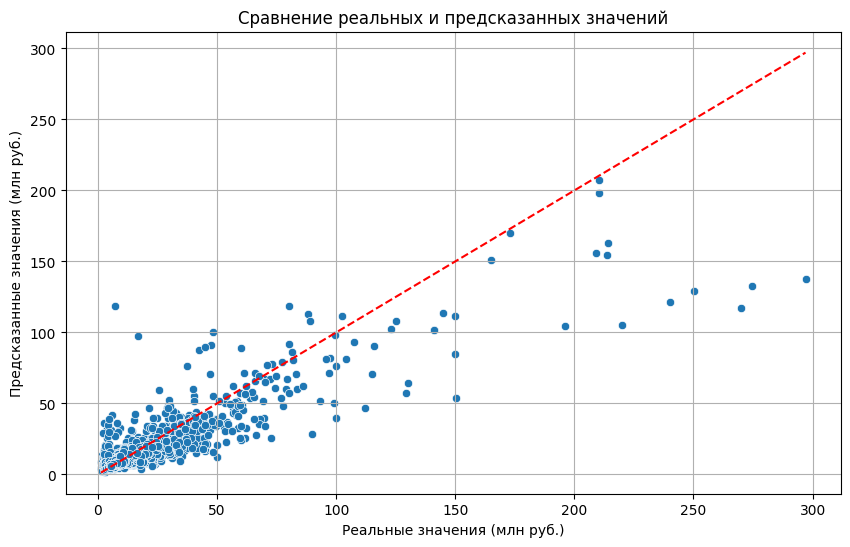

In [ ]:
# Оценка работы модели
evaluate_model(model, X_test, y_test, scaler_price, mean_price)

## **6. Случайный лес (Random Forest)**

Случайный лес - это мощный ансамблевый метод машинного обучения, который используется для классификации и регрессии. Он состоит из множества деревьев решений и объединяет их предсказания для получения более точного и устойчивого результата.

### **Теория**

Случайный лес - это мощный ансамблевый метод машинного обучения, который используется для классификации и регрессии. Он состоит из множества деревьев решений и объединяет их предсказания для получения более точного и устойчивого результата.

Основная идея случайного леса заключается в следующем:

1. **Обучение множества деревьев:** Случайный лес строит множество деревьев решений (обычно несколько сотен) на разных подвыборках исходных данных.
2. **Случайность в выборке данных и признаков:** Для каждого дерева выбирается случайная подвыборка данных и случайный подмножество признаков, что помогает уменьшить корреляцию между деревьями и улучшить обобщающую способность модели.
3. **Комбинирование предсказаний:** Для задачи регрессии случайный лес усредняет предсказания всех деревьев, а для задачи классификации выбирает класс, который был предсказан большинством деревьев.

**Пример:**

Предположим, у нас есть небольшая таблица с данными о фруктах, включающая такие признаки, как вес, цвет и тип фрукта. Мы хотим предсказать тип фрукта на основе этих признаков.

| Вес (г) | Цвет       | Тип фрукта |
|---------|------------|------------|
| 150     | Красный    | Яблоко     |
| 180     | Зеленый    | Яблоко     |
| 200     | Желтый     | Банан      |
| 170     | Красный    | Яблоко     |
| 120     | Зеленый    | Яблоко     |
| 190     | Желтый     | Банан      |

Рассмотрим, как случайный лес может строить три разных дерева:

**Дерево 1:**
- Использует признаки "Вес" и "Цвет".
- Если "Вес" > 170 и "Цвет" = Желтый, предсказывает "Банан".
- Иначе предсказывает "Яблоко".

**Дерево 2:**
- Использует только признак "Цвет".
- Если "Цвет" = Желтый, предсказывает "Банан".
- Иначе предсказывает "Яблоко".

**Дерево 3:**
- Использует только признак "Вес".
- Если "Вес" > 170, предсказывает "Банан".
- Иначе предсказывает "Яблоко".

Для нового фрукта с весом 175 г и красным цветом, предсказания деревьев будут следующими:
- Дерево 1 предсказывает "Яблоко" (потому что цвет не Желтый).
- Дерево 2 предсказывает "Яблоко" (потому что цвет не Желтый).
- Дерево 3 предсказывает "Банан" (потому что вес больше 170 г).

Случайный лес усредняет эти предсказания и выбирает "Яблоко" как окончательное предсказание, поскольку два из трех деревьев предсказали "Яблоко".




**Преимущества случайного леса:**
- Устойчивость к переобучению (overfitting) за счет случайности.
- Высокая точность предсказаний.
- Возможность обработки большого количества признаков.

**Недостатки случайного леса:**
- Большие вычислительные затраты при обучении и предсказании.
- Потеря интерпретируемости из-за сложности модели.

### **Практика**

In [ ]:
#@title Загрузка необходимых библиотек (ЗАПУСТИТЕ ЭТОТ КОД)
import pandas as pd
import numpy as np
import gdown
import warnings
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

URL = 'https://storage.yandexcloud.net/terraai/sources/flats.zip'
download_filename = gdown.download(URL, None, quiet=True)
!unzip -q {download_filename} -d '/content/data'
!rm -rf {download_filename}

# Игнорирование предупреждений
warnings.filterwarnings("ignore", category=UserWarning)

#@title Загрузка данных
def load_data():
    df = pd.read_csv('/content/data/flats.csv')
    df.drop(columns=['Источник', 'Бонус агенту', 'Дата', 'Кол-во дней в экспозиции'], inplace=True)
    df = df[df['Цена, тыс.руб.'] <= 300_000]
    df = df[df['Комнат'] == 1]
    df.drop(columns=['Комнат'], inplace=True)
    return df

# Очистка вывода
clear_output()

In [ ]:
#@title Сервисные функции (ЗАПУСТИТЕ ЭТОТ КОД)
#@title Преобразование текста в векторы
def text_to_vector(df, column, vector_size):
    vectorizer = CountVectorizer(max_features=vector_size, stop_words='english', token_pattern=r'\b\w+\b')
    text_vectors = vectorizer.fit_transform(df[column].astype('U')).toarray()
    text_vector_df = pd.DataFrame(text_vectors, columns=[f'{column}_vec_{i}' for i in range(vector_size)])
    df = pd.concat([df.reset_index(drop=True), text_vector_df.reset_index(drop=True)], axis=1)
    df.drop(columns=[column], inplace=True)
    return df

# Функция предобработки данных
def preprocess_data(df):
    # Обработка пропущенных значений
    df = df.dropna()

    # Список столбцов для OHE, исключаем 'Этаж' и 'Всего этажей в доме'
    categorical_columns = ['Тип дома', 'Балконы', 'Лоджии', 'Станция метро', 'Пешком или на транспорте', 'Санузел', 'Тип санузла']

    # Применение OHE
    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True, dtype=np.int8)

    # Нормирование столбцов Время в пути, Площадь, Этаж и Всего этажей в доме
    scaler_time = StandardScaler()
    scaler_area = StandardScaler()
    scaler_floor = StandardScaler()
    scaler_total_floors = StandardScaler()

    df[['Время в пути']] = scaler_time.fit_transform(df[['Время в пути']])
    df[['Площадь']] = scaler_area.fit_transform(df[['Площадь']])
    df[['Этаж']] = scaler_floor.fit_transform(df[['Этаж']])
    df[['Всего этажей в доме']] = scaler_total_floors.fit_transform(df[['Всего этажей в доме']])

    # Расчет средней стоимости до нормализации
    mean_price = df['Цена, тыс.руб.'].mean()

    return df, mean_price

#@title Нормирование целевых значений
def normalize_target(df):
    scaler_price = StandardScaler()
    df[['Цена, тыс.руб.']] = scaler_price.fit_transform(df[['Цена, тыс.руб.']])
    return df, scaler_price

#@title Разделение данных
def split_data(df, test_size):
    # Разделение данных на обучающую и тестовую выборки
    X = df.drop('Цена, тыс.руб.', axis=1)
    y = df['Цена, тыс.руб.']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

#@title Обучение модели случайного леса
def train_model(X_train, y_train, n_estimators):
    # Создание и обучение модели случайного леса
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    rf.fit(X_train, y_train)
    return rf

#@title Оценка модели
def evaluate_model(model, X_test, y_test, scaler_price, mean_price):
    # Предсказание и оценка модели
    y_pred = model.predict(X_test)

    # Обратное преобразование нормализованных значений
    y_test_orig = scaler_price.inverse_transform(y_test.values.reshape(-1, 1)).flatten()
    y_pred_orig = scaler_price.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    mae = mean_absolute_error(y_test_orig, y_pred_orig) / 1000  # Преобразуем в млн руб

    # Преобразуем среднюю стоимость в млн руб
    mean_price_mln = mean_price / 1000

    # Расчет процентной ошибки
    percentage_error = (mae / mean_price_mln) * 100

    print(f'Средняя абсолютная ошибка (MAE): {mae:.2f} млн руб.')
    print(f'Средняя стоимость на всей выборке: {mean_price_mln:.2f} млн руб.')
    print(f'Процентная ошибка: {percentage_error:.2f}%')

    # Вывод первых нескольких предсказанных и реальных значений
    comparison = pd.DataFrame({'Предсказанное': y_pred_orig / 1000, 'Реальное': y_test_orig / 1000}).head(10)  # Преобразуем в млн руб
    print("Сравнение предсказанных и реальных значений:")
    print(comparison)

    # Построение графика предсказанных и реальных значений
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test_orig / 1000, y=y_pred_orig / 1000)  # Преобразуем в млн руб
    plt.plot([y_test_orig.min() / 1000, y_test_orig.max() / 1000], [y_test_orig.min() / 1000, y_test_orig.max() / 1000], 'r--')  # Преобразуем в млн руб
    plt.xlabel('Реальные значения (млн руб.)')
    plt.ylabel('Предсказанные значения (млн руб.)')
    plt.title('Сравнение реальных и предсказанных значений')
    plt.grid(True)
    plt.show()

In [ ]:
# Загружаем данные
df = load_data()
df

,Станция метро,Время в пути,Пешком или на транспорте,Этаж,Всего этажей в доме,Тип дома,Балконы,Лоджии,Санузел,Тип санузла,Площадь,"Цена, тыс.руб.",Примечание
0,Шелепиха м.,12,Пешком,35,37,Монолитный,0,0,2,Не указано,64.1,19500.00,Собственность оформлена! Ключи на руках! Опера...
1,Пятницкое шоссе м.,30,На транспорте,11,14,Панельный,0,1,1,Раздельный,38.4,4800.00,Зеленоград к.1820 однокомнатная квартира общ.3...
2,Планерная м.,5,На транспорте,11,22,Панельный,1,0,1,Совмещенный,38.2,7990.00,"Уютная, светлая квартира, застекленный балкон ..."
3,Шаболовская м.,12,Пешком,8,12,Не указано,1,0,1,Раздельный,38.0,11200.00,"Предлагаю 1- комн квартиру, в шаговой доступно..."
4,Бабушкинская м.,15,Пешком,4,14,Панельный,0,0,1,Совмещенный,34.0,6250.00,Продается хорошая 1 комнатная квартира. 1 взро...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
126263,Некрасовка м.,4,Пешком,2,17,Панельный,0,0,1,Не указано,19.8,2850.00,Уникальнейшее предложение! 7 минуты до метро! ...
126264,Авиамоторная м.,6,Пешком,2,8,Кирпичный,0,0,1,Совмещенный,20.4,3839.99,ВЫГОДНОЕ ПРЕДЛОЖЕНИЕ в пешей доступности от ме...
126265,Коломенская м.,15,Пешком,1,9,Панельный,0,0,1,Не указано,15.4,2900.00,СТУДИЯ В МОСКВЕ ПО ДОСТУПНОЙ ЦЕНЕ ! __________...
126266,Алтуфьево м.,5,На транспорте,4,9,Монолитный,0,0,1,Не указано,26.0,5200.00,Продается студия с отделкой в новом монолитном...


In [ ]:
# Предобработка данных и расчет средней стоимости
df, mean_price = preprocess_data(df)
# Нормирование целевых значений
df, scaler_price = normalize_target(df)
df

,Время в пути,Этаж,Всего этажей в доме,Площадь,"Цена, тыс.руб.",Примечание,Тип дома_Деревянный,Тип дома_Железо-бетонный,Тип дома_Кирпичный,Тип дома_Монолитный,...,Станция метро_Южная м.,Станция метро_Ясенево м.,Пешком или на транспорте_Не указано,Пешком или на транспорте_Пешком,Санузел_1,Санузел_2,Санузел_3,Санузел_4,Тип санузла_Раздельный,Тип санузла_Совмещенный
0,0.325092,2.856728,1.718539,1.132717,1.080862,Собственность оформлена! Ключи на руках! Опера...,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
1,2.726350,0.117504,-0.419261,-0.118080,-0.418863,Зеленоград к.1820 однокомнатная квартира общ.3...,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,-0.608731,0.117504,0.324321,-0.127814,-0.093412,"Уютная, светлая квартира, застекленный балкон ...",0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0.325092,-0.224899,-0.605157,-0.137547,0.234079,"Предлагаю 1- комн квартиру, в шаговой доступно...",0,0,0,0,...,0,0,0,1,1,0,0,0,1,0
4,0.725301,-0.681436,-0.419261,-0.332224,-0.270931,Продается хорошая 1 комнатная квартира. 1 взро...,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126263,-0.742134,-0.909705,-0.140418,-1.023325,-0.617806,Уникальнейшее предложение! 7 минуты до метро! ...,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
126264,-0.475328,-0.909705,-0.976948,-0.994124,-0.516805,ВЫГОДНОЕ ПРЕДЛОЖЕНИЕ в пешей доступности от ме...,0,0,1,0,...,0,0,0,1,1,0,0,0,0,1
126265,0.725301,-1.023839,-0.884000,-1.237470,-0.612704,СТУДИЯ В МОСКВЕ ПО ДОСТУПНОЙ ЦЕНЕ ! __________...,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
126266,-0.608731,-0.681436,-0.884000,-0.721577,-0.378054,Продается студия с отделкой в новом монолитном...,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
# Преобразование текста в векторы
df = text_to_vector(df, 'Примечание', vector_size=500)
df

,Время в пути,Этаж,Всего этажей в доме,Площадь,"Цена, тыс.руб.",Тип дома_Деревянный,Тип дома_Железо-бетонный,Тип дома_Кирпичный,Тип дома_Монолитный,Тип дома_Не указано,...,Примечание_vec_490,Примечание_vec_491,Примечание_vec_492,Примечание_vec_493,Примечание_vec_494,Примечание_vec_495,Примечание_vec_496,Примечание_vec_497,Примечание_vec_498,Примечание_vec_499
0,0.325092,2.856728,1.718539,1.132717,1.080862,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,2.726350,0.117504,-0.419261,-0.118080,-0.418863,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.608731,0.117504,0.324321,-0.127814,-0.093412,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.325092,-0.224899,-0.605157,-0.137547,0.234079,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0.725301,-0.681436,-0.419261,-0.332224,-0.270931,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74649,-0.742134,-0.909705,-0.140418,-1.023325,-0.617806,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
74650,-0.475328,-0.909705,-0.976948,-0.994124,-0.516805,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
74651,0.725301,-1.023839,-0.884000,-1.237470,-0.612704,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74652,-0.608731,-0.681436,-0.884000,-0.721577,-0.378054,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df # Разделение выборок на обучающую и тестовую
X_train, X_test, y_train, y_test = split_data(df, test_size=0.2)

# Вывод форм выборок
print(f'Форма X_train: {X_train.shape}')
print(f'Форма X_test: {X_test.shape}')
print(f'Форма y_train: {y_train.shape}')
print(f'Форма y_test: {y_test.shape}')

Форма X_train: (59723, 791)
Форма X_test: (14931, 791)
Форма y_train: (59723,)
Форма y_test: (14931,)


In [ ]:
# Обучение модели
model = train_model(X_train, y_train, n_estimators = 100)

Средняя абсолютная ошибка (MAE): 0.85 млн руб.
Средняя стоимость на всей выборке: 8.91 млн руб.
Процентная ошибка: 9.58%
Сравнение предсказанных и реальных значений:
   Предсказанное   Реальное
0      15.148233  13.000000
1      10.240639   9.400000
2       7.451989   9.300000
3       6.813274   7.100000
4      10.375023  10.326400
5       7.288028   6.999999
6       6.141731   5.100000
7       7.192971   7.490000
8       3.219540   2.900000
9       5.587970   5.501600


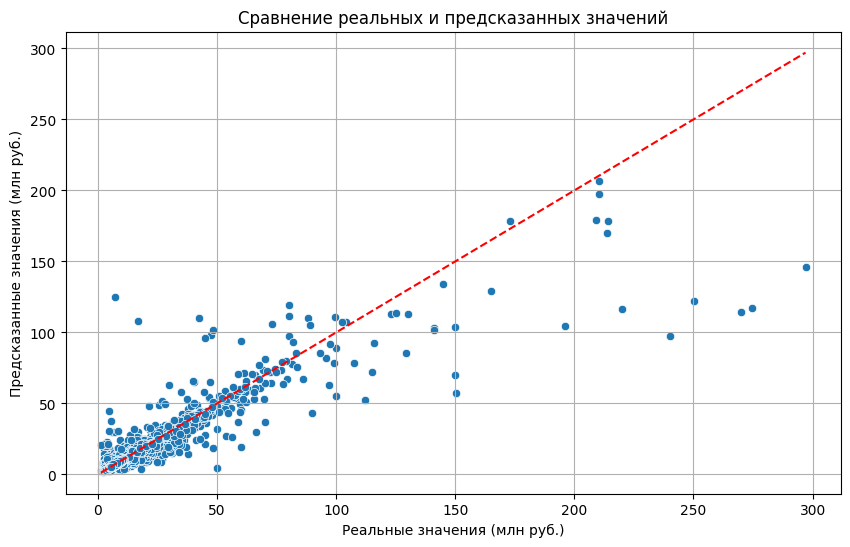

In [ ]:
# Оценка работы модели
evaluate_model(model, X_test, y_test, scaler_price, mean_price)

## **7. AutoKeras**

AutoKeras — это библиотека, которая автоматизирует процесс построения и обучения моделей машинного обучения. Хотя AutoKeras не относится напрямую к классическим методам машинного обучения, мы включили его для сравнения возможностей автоматизированных подходов в машинном обучении.

### **Практика**

In [ ]:
#@title Загрузка необходимых библиотек (ЗАПУСТИТЕ ЭТОТ КОД)
!pip install gdown autokeras tensorflow
import pandas as pd
import numpy as np
import gdown
import warnings
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import autokeras as ak
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from sklearn.metrics import mean_absolute_error

# Загрузка и распаковка данных
URL = 'https://storage.yandexcloud.net/terraai/sources/flats.zip'
download_filename = gdown.download(URL, None, quiet=True)
!unzip -q {download_filename} -d '/content/data'
!rm -rf {download_filename}

# Игнорирование предупреждений
warnings.filterwarnings("ignore", category=UserWarning)

#@title Загрузка данных
def load_data():
    df = pd.read_csv('/content/data/flats.csv')
    df.drop(columns=['Источник', 'Бонус агенту', 'Дата', 'Кол-во дней в экспозиции'], inplace=True)
    df = df[df['Цена, тыс.руб.'] <= 300_000]
    df = df[df['Комнат'] == 1]
    df.drop(columns=['Комнат'], inplace=True)
    return df

# Очистка вывода
clear_output()

In [ ]:
#@title Сервисные функции (ЗАПУСТИТЕ ЭТОТ КОД)
#@title Преобразование текста в векторы
def text_to_vector(df, column, vector_size):
    vectorizer = CountVectorizer(max_features=vector_size, stop_words='english', token_pattern=r'\b\w+\b')
    text_vectors = vectorizer.fit_transform(df[column].astype('U')).toarray()
    text_vector_df = pd.DataFrame(text_vectors, columns=[f'{column}_vec_{i}' for i in range(vector_size)])
    df = pd.concat([df.reset_index(drop=True), text_vector_df.reset_index(drop=True)], axis=1)
    df.drop(columns=[column], inplace=True)
    return df

# Функция предобработки данных
def preprocess_data(df):
    # Обработка пропущенных значений
    df = df.dropna()

    # Список столбцов для OHE, исключаем 'Этаж' и 'Всего этажей в доме'
    categorical_columns = ['Тип дома', 'Балконы', 'Лоджии', 'Станция метро', 'Пешком или на транспорте', 'Санузел', 'Тип санузла']

    # Применение OHE
    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True, dtype=np.int8)

    # Нормирование столбцов Время в пути, Площадь, Этаж и Всего этажей в доме
    scaler_time = StandardScaler()
    scaler_area = StandardScaler()
    scaler_floor = StandardScaler()
    scaler_total_floors = StandardScaler()

    df[['Время в пути']] = scaler_time.fit_transform(df[['Время в пути']])
    df[['Площадь']] = scaler_area.fit_transform(df[['Площадь']])
    df[['Этаж']] = scaler_floor.fit_transform(df[['Этаж']])
    df[['Всего этажей в доме']] = scaler_total_floors.fit_transform(df[['Всего этажей в доме']])

    # Расчет средней стоимости до нормализации
    mean_price = df['Цена, тыс.руб.'].mean()

    return df, mean_price

#@title Нормирование целевых значений
def normalize_target(df):
    scaler_price = StandardScaler()
    df[['Цена, тыс.руб.']] = scaler_price.fit_transform(df[['Цена, тыс.руб.']])
    return df, scaler_price

#@title Разделение данных
def split_data(df, test_size):
    # Разделение данных на обучающую и тестовую выборки
    X = df.drop('Цена, тыс.руб.', axis=1)
    y = df['Цена, тыс.руб.']
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

#@title Функция для создания и обучения модели (ЗАПУСТИТЕ ЭТОТ КОД)
def train_model(X_train, y_train, X_val, y_val, max_trials, tuner, epochs):
    input_node = ak.Input()
    processed_input = ak.DenseBlock()(input_node)
    output_node = ak.RegressionHead(metrics=['mae'])(processed_input)
    auto_model = ak.AutoModel(
        inputs=input_node,
        outputs=output_node,
        max_trials=max_trials,  # Максимальное количество триалов для поиска наилучшей модели
        overwrite=True,
        tuner=tuner  # Тип тюнера (жадный алгоритм)
    )
    auto_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs)
    return auto_model

#@title Оценка модели (ЗАПУСТИТЕ ЭТОТ КОД)
def evaluate_model(model, X_test, y_test, df, scaler_price, mean_price):
    y_pred = model.predict(X_test).flatten()
    y_test_actual = scaler_price.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_actual = scaler_price.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    mae = mean_absolute_error(y_test_actual, y_pred_actual) / 1000  # Преобразуем в млн руб

    # Расчет средней стоимости на всей выборке
    mean_price_mln = mean_price / 1000  # Преобразуем в млн руб

    # Расчет процентной ошибки
    percentage_error = (mae / mean_price_mln) * 100

    print(f'Средняя абсолютная ошибка (MAE): {mae:.2f} млн руб.')
    print(f'Средняя стоимость на всей выборке: {mean_price_mln:.2f} млн руб.')
    print(f'Процентная ошибка: {percentage_error:.2f}%')

    # Вывод первых нескольких предсказанных и реальных значений
    comparison = pd.DataFrame({'Предсказанное': y_pred_actual / 1000, 'Реальное': y_test_actual / 1000}).head(10)  # Преобразуем в млн руб
    print("Сравнение предсказанных и реальных значений:")
    print(comparison)

    # Построение графика предсказанных и реальных значений
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test_actual / 1000, y=y_pred_actual / 1000)  # Преобразуем в млн руб
    plt.plot([y_test_actual.min() / 1000, y_test_actual.max() / 1000], [y_test_actual.min() / 1000, y_test_actual.max() / 1000], 'r--')  # Преобразуем в млн руб
    plt.xlabel('Реальные значения (млн руб.)')
    plt.ylabel('Предсказанные значения (млн руб.)')
    plt.title('Сравнение реальных и предсказанных значений')
    plt.grid(True)
    plt.show()

In [ ]:
# Загрузка данных
df = load_data()
df

,Станция метро,Время в пути,Пешком или на транспорте,Этаж,Всего этажей в доме,Тип дома,Балконы,Лоджии,Санузел,Тип санузла,Площадь,"Цена, тыс.руб.",Примечание
0,Шелепиха м.,12,Пешком,35,37,Монолитный,0,0,2,Не указано,64.1,19500.00,Собственность оформлена! Ключи на руках! Опера...
1,Пятницкое шоссе м.,30,На транспорте,11,14,Панельный,0,1,1,Раздельный,38.4,4800.00,Зеленоград к.1820 однокомнатная квартира общ.3...
2,Планерная м.,5,На транспорте,11,22,Панельный,1,0,1,Совмещенный,38.2,7990.00,"Уютная, светлая квартира, застекленный балкон ..."
3,Шаболовская м.,12,Пешком,8,12,Не указано,1,0,1,Раздельный,38.0,11200.00,"Предлагаю 1- комн квартиру, в шаговой доступно..."
4,Бабушкинская м.,15,Пешком,4,14,Панельный,0,0,1,Совмещенный,34.0,6250.00,Продается хорошая 1 комнатная квартира. 1 взро...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
126263,Некрасовка м.,4,Пешком,2,17,Панельный,0,0,1,Не указано,19.8,2850.00,Уникальнейшее предложение! 7 минуты до метро! ...
126264,Авиамоторная м.,6,Пешком,2,8,Кирпичный,0,0,1,Совмещенный,20.4,3839.99,ВЫГОДНОЕ ПРЕДЛОЖЕНИЕ в пешей доступности от ме...
126265,Коломенская м.,15,Пешком,1,9,Панельный,0,0,1,Не указано,15.4,2900.00,СТУДИЯ В МОСКВЕ ПО ДОСТУПНОЙ ЦЕНЕ ! __________...
126266,Алтуфьево м.,5,На транспорте,4,9,Монолитный,0,0,1,Не указано,26.0,5200.00,Продается студия с отделкой в новом монолитном...


In [ ]:
# Предобработка данных и расчет средней стоимости
df, mean_price = preprocess_data(df)
# Нормирование целевых значений
df, scaler_price = normalize_target(df)
df

,Время в пути,Этаж,Всего этажей в доме,Площадь,"Цена, тыс.руб.",Примечание,Тип дома_Деревянный,Тип дома_Железо-бетонный,Тип дома_Кирпичный,Тип дома_Монолитный,...,Станция метро_Южная м.,Станция метро_Ясенево м.,Пешком или на транспорте_Не указано,Пешком или на транспорте_Пешком,Санузел_1,Санузел_2,Санузел_3,Санузел_4,Тип санузла_Раздельный,Тип санузла_Совмещенный
0,0.325092,2.856728,1.718539,1.132717,1.080862,Собственность оформлена! Ключи на руках! Опера...,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
1,2.726350,0.117504,-0.419261,-0.118080,-0.418863,Зеленоград к.1820 однокомнатная квартира общ.3...,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,-0.608731,0.117504,0.324321,-0.127814,-0.093412,"Уютная, светлая квартира, застекленный балкон ...",0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0.325092,-0.224899,-0.605157,-0.137547,0.234079,"Предлагаю 1- комн квартиру, в шаговой доступно...",0,0,0,0,...,0,0,0,1,1,0,0,0,1,0
4,0.725301,-0.681436,-0.419261,-0.332224,-0.270931,Продается хорошая 1 комнатная квартира. 1 взро...,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126263,-0.742134,-0.909705,-0.140418,-1.023325,-0.617806,Уникальнейшее предложение! 7 минуты до метро! ...,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
126264,-0.475328,-0.909705,-0.976948,-0.994124,-0.516805,ВЫГОДНОЕ ПРЕДЛОЖЕНИЕ в пешей доступности от ме...,0,0,1,0,...,0,0,0,1,1,0,0,0,0,1
126265,0.725301,-1.023839,-0.884000,-1.237470,-0.612704,СТУДИЯ В МОСКВЕ ПО ДОСТУПНОЙ ЦЕНЕ ! __________...,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
126266,-0.608731,-0.681436,-0.884000,-0.721577,-0.378054,Продается студия с отделкой в новом монолитном...,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
# Преобразование текста в векторы
df = text_to_vector(df, 'Примечание', vector_size=500)
df

,Время в пути,Этаж,Всего этажей в доме,Площадь,"Цена, тыс.руб.",Тип дома_Деревянный,Тип дома_Железо-бетонный,Тип дома_Кирпичный,Тип дома_Монолитный,Тип дома_Не указано,...,Примечание_vec_490,Примечание_vec_491,Примечание_vec_492,Примечание_vec_493,Примечание_vec_494,Примечание_vec_495,Примечание_vec_496,Примечание_vec_497,Примечание_vec_498,Примечание_vec_499
0,0.325092,2.856728,1.718539,1.132717,1.080862,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,2.726350,0.117504,-0.419261,-0.118080,-0.418863,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.608731,0.117504,0.324321,-0.127814,-0.093412,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.325092,-0.224899,-0.605157,-0.137547,0.234079,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0.725301,-0.681436,-0.419261,-0.332224,-0.270931,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74649,-0.742134,-0.909705,-0.140418,-1.023325,-0.617806,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
74650,-0.475328,-0.909705,-0.976948,-0.994124,-0.516805,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
74651,0.725301,-1.023839,-0.884000,-1.237470,-0.612704,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74652,-0.608731,-0.681436,-0.884000,-0.721577,-0.378054,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Разделение выборок на обучающую, валидационную и тестовую
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df, test_size=0.2)

# Конвертация данных в numpy.ndarray
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

# Вывод форм выборок
print(f'Форма X_train: {X_train.shape}')
print(f'Форма X_val: {X_val.shape}')
print(f'Форма X_test: {X_test.shape}')
print(f'Форма y_train: {y_train.shape}')
print(f'Форма y_val: {y_val.shape}')
print(f'Форма y_test: {y_test.shape}')

Форма X_train: (59723, 791)
Форма X_val: (7465, 791)
Форма X_test: (7466, 791)
Форма y_train: (59723,)
Форма y_val: (7465,)
Форма y_test: (7466,)


In [ ]:
# Обучение модели
model = train_model(
    X_train,  # Обучающая выборка
    y_train,  # Целевая переменная для обучения
    X_val,  # Валидационная выборка
    y_val,  # Целевая переменная для валидации
    max_trials=10,  # Количество триалов
    tuner='greedy',  # Тип тюнера
    epochs=30  # Количество эпох
)

Trial 10 Complete [00h 16m 49s]
val_loss: 0.08877287060022354

Best val_loss So Far: 0.0871250182390213
Total elapsed time: 02h 29m 08s
Epoch 1/30
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - loss: 0.3853 - mae: 0.2988 - val_loss: 0.1643 - val_mae: 0.1534
Epoch 2/30
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - loss: 0.1553 - mae: 0.1789 - val_loss: 0.1487 - val_mae: 0.1539
Epoch 3/30
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - loss: 0.1258 - mae: 0.1670 - val_loss: 0.1657 - val_mae: 0.1544
Epoch 4/30
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - loss: 0.1168 - mae: 0.1610 - val_loss: 0.1267 - val_mae: 0.1434
Epoch 5/30
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - loss: 0.1044 - mae: 0.1489 - val_loss: 0.1327 - val_mae: 0.1275
Epoch 6/30
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - loss: 0.0954 - mae: 0.1466 - val_loss: 0.1251 - val_mae: 0.1327
Epoch 7/30
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - loss: 0.0968 - mae: 0.1452 - val_loss: 0.1144 - val_mae: 0.1254
Epoch 8/30

234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Средняя абсолютная ошибка (MAE): 0.83 млн руб.
Средняя стоимость на всей выборке: 8.91 млн руб.
Процентная ошибка: 9.31%
Сравнение предсказанных и реальных значений:
   Предсказанное  Реальное
0       8.565616   8.50000
1      30.436869  30.71280
2       3.899269   3.80000
3       6.193189   5.85000
4       6.799176   6.40000
5       6.563493   6.28000
6       8.327806   8.30000
7       8.648150   9.03508
8       6.296624   6.70000
9       8.928405   7.70000


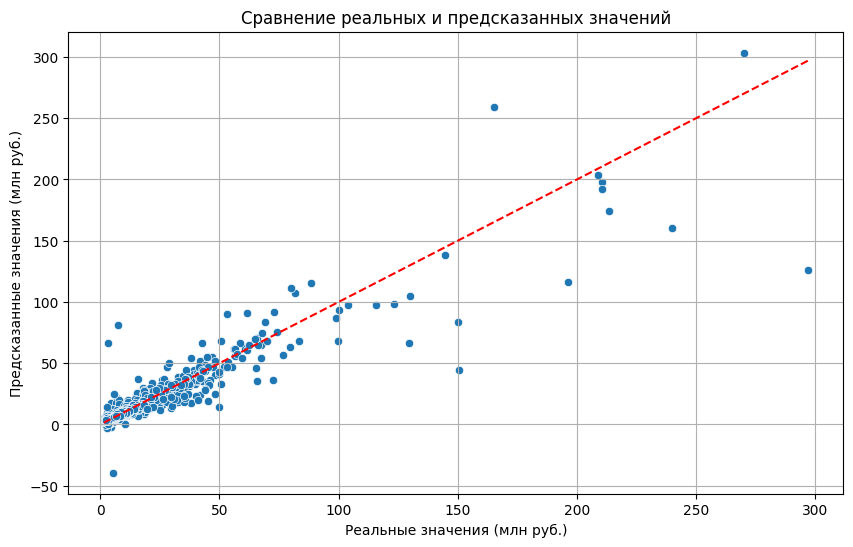

In [ ]:
# Оценка работы модели
evaluate_model(model, X_test, y_test, df, scaler_price, mean_price)

# **РЕЗУЛЬТАТЫ:**

In [ ]:
#@title Таблица результатов на полной таблице
data = {
    "Тип модели": ["Линейная регрессия", "Метод опорных векторов для регрессии", "Метод K-ближайших соседей",
                   "Байесовская линейная регрессия", "Градиентный бустинг", "Случайный лес", "AutoKeras"],
    "Средняя абсолютная ошибка, млн руб.": [2.46, 1.97, 1.02, 2.46, 1.96, 0.85, 0.83],
    "Средняя стоимость на всей выборке, млн руб.": [8.91, 8.91, 8.91, 8.91, 8.91, 8.91, 8.91],
    "Ошибка, %": [27.59, 22.08, 11.48, 27.59, 21.97, 9.58, 9.31],
    "Время обучения": ["1 мин", "3 часа", "1 минута", "2 минуты", "3 минуты", "25 минут", "2 часа 30 мин"]
}

# Создаем DataFrame
df = pd.DataFrame(data)
df


,Тип модели,"Средняя абсолютная ошибка, млн руб.","Средняя стоимость на всей выборке, млн руб.","Ошибка, %",Время обучения
0,Линейная регрессия,2.46,8.91,27.59,1 мин
1,Метод опорных векторов для регрессии,1.97,8.91,22.08,3 часа
2,Метод K-ближайших соседей,1.02,8.91,11.48,1 минута
3,Байесовская линейная регрессия,2.46,8.91,27.59,2 минуты
4,Градиентный бустинг,1.96,8.91,21.97,3 минуты
5,Случайный лес,0.85,8.91,9.58,25 минут
6,AutoKeras,0.83,8.91,9.31,2 часа 30 мин
